## Candidate # : 251046 

In [1]:
import os,random,math
from nltk import word_tokenize as tokenize
import matplotlib.pyplot as plt
import operator
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
import multiprocessing
import pandas as pd, csv
import numpy as np
import nltk
from nltk.corpus import stopwords
import string
import tqdm
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM


#### Creating Stopword + punctuation removal

In [2]:
# loading stopwords in english from nltk library
nltk.download("stopwords")
stop_word = set(stopwords.words("english"))
# storing all set of punctuation
punct = string.punctuation

# Create stopword + punctuation list.
stop_puncs = (set([x for x in punct] + list(stop_word)))

# If you have a GPU, put everything on cuda otherwise run tensors on CPU
device='cuda' if torch.cuda.is_available() else 'cpu'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jovyj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Loading pretrained model and reading questions

In [3]:
#loading Word2Vec pretrained model
filename=r"C:\Users\jovyj\Downloads\lab4resources\GoogleNews-vectors-negative300.bin"
mymodel_pretrained = KeyedVectors.load_word2vec_format(filename, binary=True)

# directory for training corpus
parentdir=r"C:\Users\jovyj\Downloads\ANLP-22\lab2resources\sentence-completion"  
trainingdir=os.path.join(parentdir,"Holmes_Training_Data")

# questions and answers for Microsoft Sentence completion challenge
questions=os.path.join(parentdir,"testing_data.csv")
answers=os.path.join(parentdir,"test_answer.csv")

# opening and reading the questions file
with open(questions) as instream:
    csvreader=csv.reader(instream)
    lines=list(csvreader)
qs_df=pd.DataFrame(lines[1:],columns=lines[0])
qs_df.head()

,id,question,a),b),c),d),e)
0,1,I have it from the same source that you are bo...,crying,instantaneously,residing,matched,walking
1,2,It was furnished partly as a sitting and partl...,daintily,privately,inadvertently,miserably,comfortably
2,3,"As I descended , my old ally , the _____ , cam...",gods,moon,panther,guard,country-dance
3,4,"We got off , _____ our fare , and the trap rat...",rubbing,doubling,paid,naming,carrying
4,5,"He held in his hand a _____ of blue paper , sc...",supply,parcel,sign,sheet,chorus


#### Splitting Training corpus

In [4]:
# function to split the training corpus into test & train
def get_training_testing(training_dir=trainingdir,split=0.5):

    filenames=os.listdir(training_dir)
    n=len(filenames)
    print("There are {} files in the training directory: {}".format(n,training_dir))
    random.seed(53)  #if you want the same random split every time
    random.shuffle(filenames)
    index=int(n*split)
    trainingfiles=filenames[:index]
    heldoutfiles=filenames[index:]  
    return trainingfiles,heldoutfiles


# Building the language model for n-gram

In [5]:
class my_language_model():
    
    """
    Class for calculating n-grams along with their probabilities. Probabilities prior to calculation are learned from
    the training corpus which comprises of 522 files. Each n-gram outputs are in individual dictionaries.
      
    Code adapted from the lab exercises written by Dr. Julie Weeds  
   
    Parameters : type
    -----------------
    
    trainingdir : str
        The training directory where training data can be found.
    files : list
        List of file names to be trained on.
    construct_params : dict
        Stores the parameters such as known words or stopword to initialize the language model with.
    
    Attributes
    ----------
    training_dir : str
        The training directory where training data can be found.
    files : list
        List of file names to be trained on.
    test_files : list
        List of file names for the model to be tested on.
    construct_params : dict
        Stores the parameters such as known to initialize the language model with.
    train : function
    
    train method will have the following dictionaries :
        unigram : dict
            Dictionary to store unigram probabilities.
        bigram : dict
            Dictionary to store bigram probabilities.
        trigram : dict
            Dictionary to store trigram probabilities.
    """
    
    def __init__(self,trainingdir=trainingdir,files=[],construct_params={}):
        self.training_dir=trainingdir
        self.files=files
        # Constructor Parameters
        self.construct_params=construct_params
        self.train()
        
    def train(self): 
        
        """
        train method will store the unigram,bigram, trigram probabilities and also call private methods such as 
        processfiles, make_unknowns, discount,kneser_ney and convert_to_probs
        
        """
        
        self.unigram={}
        self.bigram={}
        self.trigram={}
         
        self._processfiles()
        self._make_unknowns(known=self.construct_params.get("known",2))
        self._discount()
        self._kneser_ney()  
        self._convert_to_probs()
        
    def _processline(self,line):
        
        """
        This method is used to process lines of text files (corpus) and then convert corresponding sentences to tokens.
        Individual dictionaries are created for storing various n-grams
        
        """
        tokens=tokenize(line)
        if self.construct_params.get("remove_stopwords",False) == True:
            tokens = [token.lower() for token in tokens if token.lower() not in stop_puncs]
        tokens = ["__START"] + tokens + ["__END"]
        previous="__END"
        for i,token in enumerate(tokens):
            # Unigram
            self.unigram[token]=self.unigram.get(token,0)+1
            # Bigram
            current=self.bigram.get(previous,{})
            current[token]=current.get(token,0)+1
            self.bigram[previous]=current
            previous=token
            # Trigram
            if i < len(tokens)-2:
              # Next words.
              next_1 = tokens[i+1] 
              next_2 = tokens[i+2]
              # Get dictionaries.
              inner = self.trigram.get(token,{})
              innermost = inner.get(next_1,{})
              innermost[next_2] = innermost.get(token,0) + 1
              # Write frequencies to dictionaries.
              inner[next_1] = innermost
              self.trigram[token] = inner
            
    def _processfiles(self):
        
        """
        Method which Process text files.
        """
        for afile in tqdm.tqdm(self.files):
            try:
                with open(os.path.join(self.training_dir,afile)) as instream:
                    for line in instream:
                        line=line.rstrip()
                        if len(line)>0:
                            self._processline(line)
            except UnicodeDecodeError:
                print("UnicodeDecodeError processing {}: ignoring rest of file".format(afile))
                
    def _convert_to_probs(self):
        
        """
        Method to convert counts to probabilities for each n-gram dictionary.
        
        """
        self.unigram={k:v/sum(self.unigram.values()) for (k,v) in self.unigram.items()}
        self.bigram={key:{k:v/sum(adict.values()) for (k,v) in adict.items()} for (key,adict) in self.bigram.items()}
        self.trigram={k1:{k2:{k3:v/sum(adict2.values()) for k3, v in adict2.items()} for k2, adict2 in adict1.items()} for k1, adict1 in self.trigram.items()}
        self.kn={k:v/sum(self.kn.values()) for (k,v) in self.kn.items()}
        
        ###adjust __UNK probabilities to include probability of an individual unknown word (1/number_unknowns)
        self.unigram["__UNK"]=self.unigram.get("__UNK",0)/self.number_unknowns
        self.bigram["__UNK"]={k:v/self.number_unknowns for (k,v) in self.bigram.get("__UNK",{}).items()}
        for key,adict in self.bigram.items():
            adict["__UNK"]=adict.get("__UNK",0)/self.number_unknowns
            self.bigram[key]=adict
        self.kn["__UNK"]=self.kn.get("__UNK",0)/self.number_unknowns

    def get_prob(self,token,context="",methodparams={}):
        
        """
        Method to get probabilty after smoothing and discounting
        """
        if methodparams.get("method","unigram")=="unigram":
            return self.unigram.get(token,self.unigram.get("__UNK",0))
        else:
            if methodparams.get("smoothing","kneser-ney")=="kneser-ney":
                unidist=self.kn
            else:
                unidist=self.unigram
            bigram=self.bigram.get(context[-1],self.bigram.get("__UNK",{}))
            big_p=bigram.get(token,bigram.get("__UNK",0))
            lmbda=bigram["__DISCOUNT"]
            uni_p=unidist.get(token,unidist.get("__UNK",0))
            p=big_p+lmbda*uni_p            
            return p
        
    
    def compute_prob_line(self,line,methodparams={}):
        
        """
        Method to return the probability along with number of tokens after computing the probability of the line 
        according to the desired model.
        
        """
       
        # remove stopwords if required
        if self.construct_params.get("remove_stopwords",False) == True:
            tokens = [token.lower() for token in tokens if token.lower() not in stop_puncs]
        #this will add __START to the beginning of a line of text  and __END at the ending
        tokens=["__START"]+tokenize(line)+["__END"]
        acc=0
        # calling get_probs() function for computing probability of unigrams and bi-grams
        if methodparams.get("method", "unigram") in ["unigram", "bigram"]:
            for i,token in enumerate(tokens[1:]):
                acc+=math.log(self.get_prob(token,tokens[:i+1],methodparams))
            return acc,len(tokens[1:])
        # computing probability of trigrams
        if methodparams.get("method") == "trigram":
            for i, token in enumerate(tokens[1:]):
              if i < len(tokens[1:]) - 3 and len(tokens[1:]) >= 3:
                word1, word2, word3 = tokens[i+1], tokens[i+1+1], tokens[i+1+2]
                if word1 in self.trigram:
                  if word2 in self.trigram[word1]:
                    if word3 in self.trigram[word1][word2]:
                      acc+=math.log(self.trigram[word1][word2][word3])
                    else:
                      acc+=math.log(self.trigram[word1][word2]["__UNK"])
                  else:
                    if word3 in self.trigram[word1]["__UNK"]:
                      acc+=math.log(self.trigram[word1]["__UNK"][word3])
                    else: 
                      acc+=math.log(self.trigram[word1]["__UNK"]["__UNK"])
                else:
                  if word2 in self.trigram["__UNK"]:
                    if word3 in self.trigram["__UNK"][word2]:
                      acc+=math.log(self.trigram["__UNK"][word2][word3])
                    else:
                      acc+=math.log(self.trigram["__UNK"][word2]["__UNK"])
                  else:
                    if word3 in self.trigram["__UNK"]["__UNK"]:
                      acc+=math.log(self.trigram["__UNK"]["__UNK"][word3])
                    else:
                      acc+=math.log(self.trigram["__UNK"]["__UNK"]["__UNK"])
            return acc, len(tokens[1:])
        
    def compute_probability(self,filenames=[],methodparams={}):
        #computes the probability (and length) of a corpus contained in filenames
        if filenames==[]:
            filenames=self.files
        
        total_p=0
        total_N=0
        for i,afile in enumerate(filenames):
            print("Processing file {}:{}".format(i,afile))
            try:
                with open(os.path.join(self.training_dir,afile)) as instream:
                    for line in instream:
                        line=line.rstrip()
                        if len(line)>0:
                            p,N=self.compute_prob_line(line,methodparams=methodparams)
                            total_p+=p
                            total_N+=N
            except UnicodeDecodeError:
                print("UnicodeDecodeError processing file {}: ignoring rest of file".format(afile))
        return total_p,total_N
    
    def compute_perplexity(self,filenames=[],methodparams={"method":"bigram","smoothing":"kneser-ney"}):
        
        #compute the probability and length of the corpus
        #calculate perplexity
        #lower perplexity means that the model better explains the data
        
        p,N=self.compute_probability(filenames=filenames,methodparams=methodparams)
        #print(p,N)
        pp=math.exp(-p/N)
        return pp  
    
    def _make_unknowns(self,known=2):
        
        """
        Method to distribute probability mass towards the unknown token.
        
        Parameter : type
        ----------
        known : int , n-grams less frequent than the value of known will be discarded
        
        """
        unknown=0
        self.number_unknowns=0
        
        # Unigram -----------------------------------
        for (k,v) in list(self.unigram.items()):
            if v<known:
                del self.unigram[k]
                self.unigram["__UNK"]=self.unigram.get("__UNK",0)+v
                self.number_unknowns+=1
                
        # Bigram -----------------------------------
        for (k,adict) in list(self.bigram.items()):
            for (kk,v) in list(adict.items()):
                isknown=self.unigram.get(kk,0)
                if isknown==0 and not kk=="__DISCOUNT":
                    adict["__UNK"]=adict.get("__UNK",0)+v
                    del adict[kk]
            isknown=self.unigram.get(k,0)
            if isknown==0:
                del self.bigram[k]
                current=self.bigram.get("__UNK",{})
                current.update(adict)
                self.bigram["__UNK"]=current
                
            else:
                self.bigram[k]=adict
                
        # Trigram -----------------------------------
        for (k1, dict1) in list(self.trigram.items()):
          for (k2, dict2) in list(dict1.items()):
            for (k3, val) in list(dict2.items()):
              isknown=self.unigram.get(k3,0)
              if isknown == 0:
                dict2["__UNK"] = dict2.get("__UNK",0) + val
                del dict2[k3]
            isknown=self.unigram.get(k2,0)
            if isknown <= known:
              del self.trigram[k1][k2]
              current=self.trigram[k1].get("__UNK",{})
              current.update(dict2)
              self.trigram[k1]["__UNK"] = current
            else:
              self.trigram[k1][k2] = dict2
        
         # For first token:
          isknown=self.unigram.get(k1,0)
          if isknown <= known:
            del self.trigram[k1]
            current = self.trigram.get("__UNK",{})
            current.update(dict1)
            self.trigram["__UNK"] = current 
          else:
            self.trigram[k1] = dict1
            
    def _discount(self,discount=0.75):
        #discount each bigram count by a small fixed amount
        self.bigram={k:{kk:value-discount for (kk,value) in adict.items()}for (k,adict) in self.bigram.items()}
        
        #for each word, store the total amount of the discount so that the total is the same 
        #i.e., so we are reserving this as probability mass
        for k in self.bigram.keys():
            lamb=len(self.bigram[k])
            self.bigram[k]["__DISCOUNT"]=lamb*discount
            
    def _kneser_ney(self):
        #work out kneser-ney unigram probabilities
        #count the number of contexts each word has been seen in
        self.kn={}
        for (k,adict) in self.bigram.items():
            for kk in adict.keys():
                self.kn[kk]=self.kn.get(kk,0)+1

### Loading initial training dataset

In [6]:
parentdir=r"C:\Users\jovyj\Downloads\ANLP-22\lab2resources\sentence-completion" #you may need to update this 
trainingdir=os.path.join(parentdir,"Holmes_Training_Data")
training,testing=get_training_testing(trainingdir)

MAX_FILES= 10   #use a small number here whilst developing your solutions

# Initialize n-gram language model.
mylm=my_language_model(trainingdir=trainingdir,files=training[:MAX_FILES])


There are 522 files in the training directory: C:\Users\jovyj\Downloads\ANLP-22\lab2resources\sentence-completion\Holmes_Training_Data


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.68s/it]


### Building Sentence completion challenge system

In [7]:
class question:
    
    """
    Class for storing the questions from Microsoft sentence completion challege dataset.
      
    Code adapted from the lab exercises written by Dr. Julie Weeds  
   
    Parameters : type
    -----------------
    
    aline : str
        The training directory where training data can be found.
   
    
    Attributes
    ----------
    fields : str
        The training directory where training data can be found.
    answers : dict
        Dictionary storing the chocies for answers to the challenge.
    options : list
        List of options for answers to the challenge.

    """       
    def __init__(self,aline):
        self.fields=aline
        self.answers = {
            0:"a",
            1:"b",
            2:"c",
            3:"d",
            4:"e"
            }

        self.options = self.fields[2:7]
  
    def get_tokens(self):
        
        """
        Method to tokenize the question, starting with __START and ending with __END
        """
        return ["__START"]+tokenize(self.fields[question.colnames["question"]])+["__END"]
    
    def get_field(self,field):
        """
        Method to get all the fields from each question file
        """
        return self.fields[question.colnames[field]]
    
    def add_answer(self,fields):
        """
        Method to get the answer to each question
        """
        self.answer=fields[1]
   
    
    def get_left_context(self,window=1,target="_____"):
        
        """
        Method to return the left context of a target word in question sentence. 
          
        """
         
        found=-1
        sent_tokens=self.get_tokens()
        for i,token in enumerate(sent_tokens):
            if token==target:
                found=i
                break  
            
        if found>-1:
            return sent_tokens[i-window:i]
        else:
            return []
        
    
    qs_df['tokens']=qs_df['question'].map(tokenize)
    #qs_df['left_context']=qs_df['tokens'].map(lambda x: get_left_context(x,2))
    qs_df[:10]
    
        
    def get_right_context(self,window=1,target="_____"):
        
        """
        Method to return the right context of a target word in question sentence. 
        
        """
        found=-1
        sent_tokens=self.get_tokens()
        for i,token in enumerate(sent_tokens):
            if token==target:
                found=i
                break  
          
        if found>-1:
            
            return sent_tokens[found+1:found+window+1]
           
        else:
            return []    
             
    def chooserandom(self):
        
        """
        Retrun a random choice among the options.
        """
        choices=["a","b","c","d","e"]
        return np.random.choice(choices)
    
    def chooseunigram(self,lm):
        
        """
        Return position of word with greatest unigram probability. 0 otherwise.
        """
        choices=["a","b","c","d","e"]      
        probs=[lm.unigram.get(self.get_field(ch+")"),0) for ch in choices] 
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)
    
    def choosebigram(self,lm,method="bigram_left",choices=[]):
        
        """
        Return position of word-pair with greatest bigram probability. 0 otherwise. 
        
        """
        if choices==[]:
            choices=["a","b","c","d","e"]
            
        if method=="bigram_right":
            context=self.get_right_context(window=1)
            probs=[lm.get_prob(context[0],[self.get_field(ch+")")],methodparams={"method":method.split("_")[0]}) for ch in choices]
        else:
            context=self.get_left_context(window=1)
            probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":method.split("_")[0]}) for ch in choices]
            
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return np.random.choice(bestchoices)
    
    def choose_backoff(self,lm,methods=['bigram','unigram'],choices=["a","b","c","d","e"]):
        """
        bigram back off 
        
        """
        context=self.get_left_context(window=1)
        probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":methods[0]}) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        return self.choosebigram(lm,choices=bestchoices,method=methods[1])
    
    def choose_backoff_trigram(self,lm,methods=['trigram','bigram','unigram'],choices=["a","b","c","d","e"]):
        """
        trigram back off 
        
        """
        context=self.get_left_context(window=2)
        probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":methods[0]}) for ch in choices]
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
       # if len(bestchoices)>1:
       #     print("Backing off on {}".format(len(bestchoices)))
        return self.choosetrigram(lm,choices=bestchoices,method=methods[1])
    
    def choosetrigram(self,lm, method="trigram_left",choices=[]):
        
        """
        Return position of word-group with greatest trigram probability. 0 otherwise. 
        
        """
        if choices==[]:
            choices=["a","b","c","d","e"]
        if method=="trigram_right":
            context=self.get_right_context(window=2)           
            probs=[lm.get_prob(context[1],[self.get_field(ch+")")]+[context[0]],methodparams={"method":method.split("_")[0]}) for ch in choices]
        else:
            context=self.get_left_context(window=2)
          #  print("\n",context)
            probs=[lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":method.split("_")[0]}) for ch in choices]
         #   print("\n",probs)
        
        maxprob=max(probs)
        bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
        #if len(bestchoices)>1:
        #    print("Randomly choosing from {}".format(len(bestchoices)))
        return np.random.choice(bestchoices)
    
    def embedding_similarity(self, method="cos"):
      """
      Method for Word2Vec word embedding trained on gutenberg corpus
      """
      option_probs = []
      # Remove target string.
      sentence = self.get_tokens() #.remove("_____")
      # Iterate through candidate choices.   
      for word in self.options:       
          # If no embedding for that word exists.
          if word not in mymodel.wv:
            option_probs.append(0)
            # Continue to next candidate word.
            continue
          # Get vectorized form of word.
          word_vector = mymodel.wv.get_vector(word)
          # Get vectorized form of sentence tokens.
          sentence_vectors = [mymodel.wv.get_vector(sent_token) for sent_token in sentence if sent_token in mymodel.wv and sent_token != "_____"]
          # For euclidean distances.
          if method == "euc":
            sim_score = [np.linalg.norm(mymodel.wv.get_vector(word) - mymodel.wv.get_vector(sent_token)) for sent_token in sentence if sent_token in mymodel.wv and sent_token != "_____"]
          # For cosine distances.
          else:
            sim_score = mymodel.wv.cosine_similarities(word_vector, sentence_vectors)
          # Append average "method" similarity.
          option_probs.append(sum(sim_score)/len(sim_score))

      if method == "cos":
        index = option_probs.index(max(option_probs))
      else:
        index = option_probs.index(min(option_probs))
      return self.answers[index]
    
    def embedding_similarity_pretrained(self, method="cos"):
      """
      Method for Word2Vec word embedding from a pretained BIN file (GoogleNews-vectors-negative300.bin)
      """
      option_probs = []
      # Remove target string.
      sentence = self.get_tokens() #.remove("_____")
      # Iterate through candidate choices.   
      for word in self.options:       
          # If no embedding for that word exists.
          if word not in mymodel_pretrained:
            option_probs.append(0)
            # Continue to next candidate word.
            continue
          # Get vectorized form of word.
          word_vector = mymodel_pretrained.get_vector(word)
          # Get vectorized form of sentence tokens.
          sentence_vectors = [mymodel_pretrained.get_vector(sent_token) for sent_token in sentence if sent_token in mymodel_pretrained and sent_token != "_____"]
          # For euclidean distances.
          if method == "euc":
            sim_score = [np.linalg.norm(mymodel_pretrained.get_vector(word) - mymodel_pretrained.get_vector(sent_token)) for sent_token in sentence if sent_token in mymodel_pretrained and sent_token != "_____"]
          # For cosine distances.
          else:
            sim_score = mymodel_pretrained.cosine_similarities(word_vector, sentence_vectors)
          # Append average "method" similarity.
          option_probs.append(sum(sim_score)/len(sim_score))

      if method == "cos":
        index = option_probs.index(max(option_probs))
      else:
        index = option_probs.index(min(option_probs))
      return self.answers[index]

    def predict(self,method="unigram",lm=mylm):
        if method=="unigram":
            return self.chooseunigram(lm=lm)
        elif method=="bigram_left":
            return self.choosebigram(lm=lm)
        elif method=="bigram_right":
            return self.choosebigram(lm=lm,method="bigram_right")
        elif method=="bigram_backoff":
            return self.choose_backoff(lm=lm,methods=["bigram","unigram"])
        elif method=="trigram_left":
            return self.choosetrigram(lm=lm)
        elif method=="trigram_right":
            return self.choosetrigram(lm=lm,method="trigram_right")
        elif method=="trigram_backoff":
            return self.choose_backoff_trigram(lm=lm,methods=["trigram","bigram","unigram"])
        elif method=="embedding_similarity_euc":
            return self.embedding_similarity(method="euc")
        elif method=="embedding_similarity_cos":
            return self.embedding_similarity(method="cos")
        elif method=="embedding_similarity_pretrained_cos":
            return self.embedding_similarity_pretrained(method="cos")
        elif method=="embedding_similarity_pretrained_euc":
            return self.embedding_similarity_pretrained(method="euc")
        
        
    def predict_and_score(self,method="unigram"):
        
        #compare prediction according to method with the correct answer
        #return 1 or 0 accordingly
        prediction=self.predict(method=method)
        if prediction ==self.answer:
            correct_answers.get(method).append(1)
            return 1
        else:
            correct_answers.get(method).append(0)
            return 0

In [8]:
class scc_reader:
    
    def __init__(self,qs=questions,ans=answers):
        self.qs=qs
        self.ans=ans
        self.read_files()
        
    def read_files(self):
        
        #read in the question file
        with open(self.qs) as instream:
            csvreader=csv.reader(instream)
            qlines=list(csvreader)
        
        #store the column names as a reverse index so they can be used to reference parts of the question
        question.colnames={item:i for i,item in enumerate(qlines[0])}
        
        #create a question instance for each line of the file (other than heading line)
        self.questions=[question(qline) for qline in qlines[1:]]
        
        #read in the answer file
        with open(self.ans) as instream:
            csvreader=csv.reader(instream)
            alines=list(csvreader)
            
        #add answers to questions so predictions can be checked    
        for q,aline in zip(self.questions,alines[1:]):
            q.add_answer(aline)
        
    def get_field(self,field):
        return [q.get_field(field) for q in self.questions] 
    
    def predict(self,method="unigram"):
        return [q.predict(method=method) for q in self.questions]
    
    def predict_and_score(self,method="unigram"):
        scores=[q.predict_and_score(method=method) for q in self.questions]
        return sum(scores)/len(scores)
    

In [10]:
# dictionary to store the correct answers predicted by various methods
correct_answers = {"bigram_left":[],"bigram_right":[],"bigram_backoff":[],"unigram":[] ,"trigram_left" : [],"trigram_right" : [],"trigram_backoff" : [], "embedding_similarity_cos" : [],"embedding_similarity_euc" : [], "embedding_similarity_pretrained_cos" : [],"embedding_similarity_pretrained_euc" : [] }

### N-Gram Accuracy with stopwords removed

In [64]:
# training file size
MAX_FILES=50

## lists for storing accuracy of various methods
trigram_right_accuracy_stopword=[]
trigram_left_accuracy_stopword=[]
bigram_right_accuracy_stopword=[]
bigram_left_accuracy_stopword=[]
unigram_accuracy_stopword=[]

# stopwords are being removed from training corpus
for known in [5, 10, 20, 50, 75]:
        construct_params = {
            "known" : known,
            "remove_stopwords" : True
        }

        # Initialize n-gram language model.
        mylm=my_language_model(trainingdir=trainingdir,files=training[:MAX_FILES], construct_params=construct_params)
        SCC = scc_reader()
        # Accuracy of method="trigram_right"
        trigram_right=SCC.predict_and_score(method="trigram_right")
        trigram_right_accuracy_stopword.append(trigram_right)
        # Accuracy of method="trigram_left"
        trigram_left=SCC.predict_and_score(method="trigram_left")
        trigram_left_accuracy_stopword.append(trigram_left)
        # Accuracy of method= "bigram_right"
        bigram_right=SCC.predict_and_score(method="bigram_right")
        bigram_right_accuracy_stopword.append(bigram_right)
        # Accuracy of method="bigram_left"
        bigram_left=SCC.predict_and_score(method="bigram_left")
        bigram_left_accuracy_stopword.append(bigram_left)
        # Accuracy of method="unigram"
        unigram=SCC.predict_and_score(method="unigram")
        unigram_accuracy_stopword.append(unigram)

        print("Trained on {} files, Accuracy of trigram_right with {} known words = {}".format(MAX_FILES,known,trigram_right))
        print("Trained on {} files, Accuracy of trigram_left with {} known words = {}".format(MAX_FILES,known,trigram_left))
        print("Trained on {} files, Accuracy of bigram_right with {} known words  = {}".format(MAX_FILES,known,bigram_right))
        print("Trained on {} files, Accuracy of bigram_left with {} known words = {}".format(MAX_FILES,known,bigram_left))
        print("Trained on {} files, Accuracy of unigram with {} known words  = {}".format(MAX_FILES,known,unigram))

# initialize pandas dataframe.
df_stop=pd.DataFrame()
df_1=pd.DataFrame()
for i, known in enumerate ([5, 10, 20, 50, 75]):
    data ={
    'known_words': known ,
    "trigram_right": trigram_right_accuracy_stopword[i],
    "trigram_left" :  trigram_left_accuracy_stopword[i],
    "bigram_right":bigram_right_accuracy_stopword[i],
    "bigram_left": bigram_left_accuracy_stopword[i],   
    "unigram":unigram_accuracy_stopword[i]}
    df_stop=pd.DataFrame(data, index=data.keys())
    df_1=df_1.append(df_stop[:1])
    df_stop=pd.DataFrame()
    
df_stopword_result=df_1.reset_index(drop=True)
print("\n\nSummary of N-Grams outcomes with stopwords removed (on training fileset)")
df_stopword_result

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:25<00:00,  1.71s/it]


Trained on 50 files, Accuracy of trigram_right with 5 known words = 0.19615384615384615
Trained on 50 files, Accuracy of trigram_left with 5 known words = 0.2932692307692308
Trained on 50 files, Accuracy of bigram_right with 5 known words  = 0.21057692307692308
Trained on 50 files, Accuracy of bigram_left with 5 known words = 0.29134615384615387
Trained on 50 files, Accuracy of unigram with 5 known words  = 0.26346153846153847


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:05<00:00,  1.31s/it]


Trained on 50 files, Accuracy of trigram_right with 10 known words = 0.19423076923076923
Trained on 50 files, Accuracy of trigram_left with 10 known words = 0.28942307692307695
Trained on 50 files, Accuracy of bigram_right with 10 known words  = 0.2125
Trained on 50 files, Accuracy of bigram_left with 10 known words = 0.2875
Trained on 50 files, Accuracy of unigram with 10 known words  = 0.2605769230769231


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:07<00:00,  1.36s/it]


Trained on 50 files, Accuracy of trigram_right with 20 known words = 0.20576923076923076
Trained on 50 files, Accuracy of trigram_left with 20 known words = 0.2923076923076923
Trained on 50 files, Accuracy of bigram_right with 20 known words  = 0.2201923076923077
Trained on 50 files, Accuracy of bigram_left with 20 known words = 0.2923076923076923
Trained on 50 files, Accuracy of unigram with 20 known words  = 0.26346153846153847


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:06<00:00,  1.33s/it]


Trained on 50 files, Accuracy of trigram_right with 50 known words = 0.1875
Trained on 50 files, Accuracy of trigram_left with 50 known words = 0.2923076923076923
Trained on 50 files, Accuracy of bigram_right with 50 known words  = 0.2173076923076923
Trained on 50 files, Accuracy of bigram_left with 50 known words = 0.29134615384615387
Trained on 50 files, Accuracy of unigram with 50 known words  = 0.26153846153846155


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.19s/it]


Trained on 50 files, Accuracy of trigram_right with 75 known words = 0.18365384615384617
Trained on 50 files, Accuracy of trigram_left with 75 known words = 0.2932692307692308
Trained on 50 files, Accuracy of bigram_right with 75 known words  = 0.21634615384615385
Trained on 50 files, Accuracy of bigram_left with 75 known words = 0.2923076923076923
Trained on 50 files, Accuracy of unigram with 75 known words  = 0.2605769230769231


Summary of N-Grams outcomes with stopwords removed (on training fileset)


,known_words,trigram_right,trigram_left,bigram_right,bigram_left,unigram
0,5,0.196154,0.293269,0.210577,0.291346,0.263462
1,10,0.194231,0.289423,0.212500,0.287500,0.260577
2,20,0.205769,0.292308,0.220192,0.292308,0.263462
3,50,0.187500,0.292308,0.217308,0.291346,0.261538
4,75,0.183654,0.293269,0.216346,0.292308,0.260577


###  N-Gram outcomes without stopword removal

In [65]:
# training file size
MAX_FILES=50

## lists for storing accuracy of various methods
trigram_right_accuracy=[]
trigram_left_accuracy=[]
bigram_right_accuracy=[]
bigram_left_accuracy=[]
unigram_accuracy=[]

# Stopwords are not removed from training corpus
for known in [5, 10, 20, 50, 75]:
        construct_params = {
            "known" : known,
            "remove_stopwords" : False
        }

        # Initialize n-gram language model.
        mylm=my_language_model(trainingdir=trainingdir,files=training[:MAX_FILES], construct_params=construct_params)
        SCC = scc_reader()
        # Accuracy of method="trigram_right"
        trigram_right=SCC.predict_and_score(method="trigram_right")
        trigram_right_accuracy.append(trigram_right)
        # Accuracy of method="trigram_left"
        trigram_left=SCC.predict_and_score(method="trigram_left")
        trigram_left_accuracy.append(trigram_left)
        # Accuracy of method="bigram_right"
        bigram_right=SCC.predict_and_score(method="bigram_right")
        bigram_right_accuracy.append(bigram_right)
        # Accuracy of method="bigram_left"
        bigram_left=SCC.predict_and_score(method="bigram_left")
        bigram_left_accuracy.append(bigram_left)
        # Accuracy of method="unigram"
        unigram=SCC.predict_and_score(method="unigram")
        unigram_accuracy.append(unigram)

        print("Trained on {} files, Accuracy of trigram_right with {} known words = {}".format(MAX_FILES,known,trigram_right))
        print("Trained on {} files, Accuracy of trigram_left with {} known words = {}".format(MAX_FILES,known,trigram_left))
        print("Trained on {} files, Accuracy of bigram_right with {} known words  = {}".format(MAX_FILES,known,bigram_right))
        print("Trained on {} files, Accuracy of bigram_left with {} known words = {}".format(MAX_FILES,known,bigram_left))
        print("Trained on {} files, Accuracy of unigram with {} known words  = {}".format(MAX_FILES,known,unigram))
        

# initialize pandas dataframe
df_res=pd.DataFrame()
df1=pd.DataFrame()
for i, known in enumerate ([5, 10, 20, 50, 75]):
    data ={
    'known_words': known ,
    "trigram_right": trigram_right_accuracy[i],
    "trigram_left" :  trigram_left_accuracy[i],
    "bigram_right":bigram_right_accuracy[i],
    "bigram_left": bigram_left_accuracy[i],   
    "unigram":unigram_accuracy[i]}
    df_res=pd.DataFrame(data, index=data.keys())
    df1=df1.append(df_res[:1])
    df_res=pd.DataFrame()
  
df_result=df1.reset_index(drop=True)

print("\n\nSummary of N-Grams Accuracy without stopwords removal (on training set)")
df_result
        

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:04<00:00,  1.29s/it]


Trained on 50 files, Accuracy of trigram_right with 5 known words = 0.21346153846153845
Trained on 50 files, Accuracy of trigram_left with 5 known words = 0.29134615384615387
Trained on 50 files, Accuracy of bigram_right with 5 known words  = 0.21153846153846154
Trained on 50 files, Accuracy of bigram_left with 5 known words = 0.29423076923076924
Trained on 50 files, Accuracy of unigram with 5 known words  = 0.2605769230769231


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:08<00:00,  1.37s/it]


Trained on 50 files, Accuracy of trigram_right with 10 known words = 0.19807692307692307
Trained on 50 files, Accuracy of trigram_left with 10 known words = 0.2951923076923077
Trained on 50 files, Accuracy of bigram_right with 10 known words  = 0.2153846153846154
Trained on 50 files, Accuracy of bigram_left with 10 known words = 0.29134615384615387
Trained on 50 files, Accuracy of unigram with 10 known words  = 0.2605769230769231


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:08<00:00,  1.38s/it]


Trained on 50 files, Accuracy of trigram_right with 20 known words = 0.20384615384615384
Trained on 50 files, Accuracy of trigram_left with 20 known words = 0.2903846153846154
Trained on 50 files, Accuracy of bigram_right with 20 known words  = 0.21057692307692308
Trained on 50 files, Accuracy of bigram_left with 20 known words = 0.29134615384615387
Trained on 50 files, Accuracy of unigram with 20 known words  = 0.26153846153846155


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:08<00:00,  1.38s/it]


Trained on 50 files, Accuracy of trigram_right with 50 known words = 0.1798076923076923
Trained on 50 files, Accuracy of trigram_left with 50 known words = 0.29134615384615387
Trained on 50 files, Accuracy of bigram_right with 50 known words  = 0.21346153846153845
Trained on 50 files, Accuracy of bigram_left with 50 known words = 0.2923076923076923
Trained on 50 files, Accuracy of unigram with 50 known words  = 0.2653846153846154


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:11<00:00,  1.43s/it]


Trained on 50 files, Accuracy of trigram_right with 75 known words = 0.19903846153846153
Trained on 50 files, Accuracy of trigram_left with 75 known words = 0.28942307692307695
Trained on 50 files, Accuracy of bigram_right with 75 known words  = 0.2153846153846154
Trained on 50 files, Accuracy of bigram_left with 75 known words = 0.2932692307692308
Trained on 50 files, Accuracy of unigram with 75 known words  = 0.26153846153846155


Summary of N-Grams Accuracy without stopwords removal (on training set)


,known_words,trigram_right,trigram_left,bigram_right,bigram_left,unigram
0,5,0.213462,0.291346,0.211538,0.294231,0.260577
1,10,0.198077,0.295192,0.215385,0.291346,0.260577
2,20,0.203846,0.290385,0.210577,0.291346,0.261538
3,50,0.179808,0.291346,0.213462,0.292308,0.265385
4,75,0.199038,0.289423,0.215385,0.293269,0.261538


### Increasing Training dataset files for n-grams

In [66]:
# training file size
MAX_FILES= 100

## lists for storing accuracy of various methods
trigram_left_accuracy=[]
bigram_left_accuracy=[]
unigram_accuracy=[]

# Stopwords are not removed from training corpus
for known in [5, 10, 20, 50, 75]:
        construct_params = {
            "known" : known,
            "remove_stopwords" : False
        }

        # Initialize n-gram language model.
        mylm=my_language_model(trainingdir=trainingdir,files=training[:MAX_FILES], construct_params=construct_params)
        SCC = scc_reader()
        # Accuracy of method="trigram_left"
        trigram_left=SCC.predict_and_score(method="trigram_left")
        trigram_left_accuracy.append(trigram_left)
        # Accuracy of method="bigram_left"        
        bigram_left=SCC.predict_and_score(method="bigram_left")
        bigram_left_accuracy.append(bigram_left)
        # Accuracy of method="unigram"
        unigram=SCC.predict_and_score(method="unigram")
        unigram_accuracy.append(unigram)
        
        
        print("Trained on {} files, Accuracy of trigram_left with {} known words = {}".format(MAX_FILES,known,trigram_left))
        print("Trained on {} files, Accuracy of bigram_left with {} known words = {}".format(MAX_FILES,known,bigram_left))
        print("Trained on {} files, Accuracy of unigram with {} known words  = {}".format(MAX_FILES,known,unigram))

# initialize pandas dataframe.
df_res=pd.DataFrame()
df1=pd.DataFrame()
for i, known in enumerate ([5, 10, 20, 50, 75]):
    data ={
    'known_words': known ,
    "trigram_left" :  trigram_left_accuracy[i],
    "bigram_left": bigram_left_accuracy[i],   
    "unigram":unigram_accuracy[i]}
    df_res=pd.DataFrame(data, index=data.keys())
    df1=df1.append(df_res[:1])
    df_res=pd.DataFrame()

df_result=df1.reset_index(drop=True)
print("\n\nSummary of N-Grams Accuracy without stopwords removal (on training set of MAX_FILES= {})".format(MAX_FILES))
df_result
        

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.36s/it]


Trained on 100 files, Accuracy of trigram_left with 5 known words = 0.2875
Trained on 100 files, Accuracy of bigram_left with 5 known words = 0.28942307692307695
Trained on 100 files, Accuracy of unigram with 5 known words  = 0.2653846153846154


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:08<00:00,  1.28s/it]


Trained on 100 files, Accuracy of trigram_left with 10 known words = 0.2932692307692308
Trained on 100 files, Accuracy of bigram_left with 10 known words = 0.2903846153846154
Trained on 100 files, Accuracy of unigram with 10 known words  = 0.26346153846153847


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:03<00:00,  1.23s/it]


Trained on 100 files, Accuracy of trigram_left with 20 known words = 0.2932692307692308
Trained on 100 files, Accuracy of bigram_left with 20 known words = 0.2903846153846154
Trained on 100 files, Accuracy of unigram with 20 known words  = 0.2605769230769231


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:06<00:00,  1.26s/it]


Trained on 100 files, Accuracy of trigram_left with 50 known words = 0.2903846153846154
Trained on 100 files, Accuracy of bigram_left with 50 known words = 0.29134615384615387
Trained on 100 files, Accuracy of unigram with 50 known words  = 0.26346153846153847


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.23s/it]


Trained on 100 files, Accuracy of trigram_left with 75 known words = 0.28942307692307695
Trained on 100 files, Accuracy of bigram_left with 75 known words = 0.29423076923076924
Trained on 100 files, Accuracy of unigram with 75 known words  = 0.26346153846153847


Summary of N-Grams Accuracy without stopwords removal (on training set of MAX_FILES= 100)


,known_words,trigram_left,bigram_left,unigram
0,5,0.287500,0.289423,0.265385
1,10,0.293269,0.290385,0.263462
2,20,0.293269,0.290385,0.260577
3,50,0.290385,0.291346,0.263462
4,75,0.289423,0.294231,0.263462


In [67]:
MAX_FILES= 200


## lists for storing accuracy of various methods
trigram_left_accuracy=[]
bigram_left_accuracy=[]
unigram_accuracy=[]

# Stopwords are not removed from training corpus
for known in [5, 10, 20, 50, 75]:
        construct_params = {
            "known" : known,
            "remove_stopwords" : False
        }

        # Initialize n-gram language model.
        mylm=my_language_model(trainingdir=trainingdir,files=training[:MAX_FILES], construct_params=construct_params)
        SCC = scc_reader()
        # Accuracy of method="trigram_left"
        trigram_left=SCC.predict_and_score(method="trigram_left")
        trigram_left_accuracy.append(trigram_left)
        # Accuracy of method="bigram_left"        
        bigram_left=SCC.predict_and_score(method="bigram_left")
        bigram_left_accuracy.append(bigram_left)
        # Accuracy of method="unigram"
        unigram=SCC.predict_and_score(method="unigram")
        unigram_accuracy.append(unigram)
        
        
        print("Trained on {} files, Accuracy of trigram_left with {} known words = {}".format(MAX_FILES,known,trigram_left))
        print("Trained on {} files, Accuracy of bigram_left with {} known words = {}".format(MAX_FILES,known,bigram_left))
        print("Trained on {} files, Accuracy of unigram with {} known words  = {}".format(MAX_FILES,known,unigram))

# initialize pandas dataframe.
df_res=pd.DataFrame()
df1=pd.DataFrame()
for i, known in enumerate ([5, 10, 20, 50, 75]):
    data ={
    'known_words': known ,
    "trigram_left" :  trigram_left_accuracy[i],
    "bigram_left": bigram_left_accuracy[i],   
    "unigram":unigram_accuracy[i]}
    df_res=pd.DataFrame(data, index=data.keys())
    df1=df1.append(df_res[:1])
    df_res=pd.DataFrame()

    
df_result=df1.reset_index(drop=True)
print("\n\nSummary of N-Grams Accuracy without stopwords removal (on training set of MAX_FILES= {})".format(MAX_FILES))
df_result
        

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [04:06<00:00,  1.23s/it]


Trained on 200 files, Accuracy of trigram_left with 5 known words = 0.28942307692307695
Trained on 200 files, Accuracy of bigram_left with 5 known words = 0.2923076923076923
Trained on 200 files, Accuracy of unigram with 5 known words  = 0.26346153846153847


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [05:53<00:00,  1.77s/it]


Trained on 200 files, Accuracy of trigram_left with 10 known words = 0.29134615384615387
Trained on 200 files, Accuracy of bigram_left with 10 known words = 0.2903846153846154
Trained on 200 files, Accuracy of unigram with 10 known words  = 0.26153846153846155


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [04:18<00:00,  1.29s/it]


Trained on 200 files, Accuracy of trigram_left with 20 known words = 0.2932692307692308
Trained on 200 files, Accuracy of bigram_left with 20 known words = 0.2923076923076923
Trained on 200 files, Accuracy of unigram with 20 known words  = 0.2625


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [04:19<00:00,  1.30s/it]


Trained on 200 files, Accuracy of trigram_left with 50 known words = 0.2932692307692308
Trained on 200 files, Accuracy of bigram_left with 50 known words = 0.2932692307692308
Trained on 200 files, Accuracy of unigram with 50 known words  = 0.2605769230769231


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [04:06<00:00,  1.23s/it]


Trained on 200 files, Accuracy of trigram_left with 75 known words = 0.29134615384615387
Trained on 200 files, Accuracy of bigram_left with 75 known words = 0.29134615384615387
Trained on 200 files, Accuracy of unigram with 75 known words  = 0.2605769230769231


Summary of N-Grams Accuracy without stopwords removal (on training set of MAX_FILES= 200)


,known_words,trigram_left,bigram_left,unigram
0,5,0.289423,0.292308,0.263462
1,10,0.291346,0.290385,0.261538
2,20,0.293269,0.292308,0.262500
3,50,0.293269,0.293269,0.260577
4,75,0.291346,0.291346,0.260577


In [11]:
MAX_FILES= 260

## lists for storing accuracy of various methods
trigram_left_accuracy=[]
bigram_left_accuracy=[]
unigram_accuracy=[]

# Stopwords are not removed from training corpus
for known in [5, 10, 20, 50, 75]:
        construct_params = {
            "known" : known,
            "remove_stopwords" : False
        }

        # Initialize n-gram language model.
        mylm=my_language_model(trainingdir=trainingdir,files=training[:MAX_FILES], construct_params=construct_params)
        SCC = scc_reader()
        # Accuracy of method="trigram_left"
        trigram_left=SCC.predict_and_score(method="trigram_left")
        trigram_left_accuracy.append(trigram_left)
        # Accuracy of method="bigram_left"        
        bigram_left=SCC.predict_and_score(method="bigram_left")
        bigram_left_accuracy.append(bigram_left)
        # Accuracy of method="unigram"
        unigram=SCC.predict_and_score(method="unigram")
        unigram_accuracy.append(unigram)
        
        
        print("Trained on {} files, Accuracy of trigram_left with {} known words = {}".format(MAX_FILES,known,trigram_left))
        print("Trained on {} files, Accuracy of bigram_left with {} known words = {}".format(MAX_FILES,known,bigram_left))
        print("Trained on {} files, Accuracy of unigram with {} known words  = {}".format(MAX_FILES,known,unigram))

# initialize pandas dataframe.
df_res=pd.DataFrame()
df1=pd.DataFrame()
for i, known in enumerate ([5, 10, 20, 50, 75]):
    data ={
    'known_words': known ,
    "trigram_left" :  trigram_left_accuracy[i],
    "bigram_left": bigram_left_accuracy[i],   
    "unigram":unigram_accuracy[i]}
    df_res=pd.DataFrame(data, index=data.keys())
    df1=df1.append(df_res[:1])
    df_res=pd.DataFrame()

    
#df = pd.DataFrame(data)
# Create the pandas DataFrame
#df1
df_result=df1.reset_index(drop=True)

print("\n\nSummary of N-Grams Accuracy without stopwords removal (on training set of MAX_FILES= {})".format(MAX_FILES))
df_result
        

100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [12:34<00:00,  2.90s/it]


Trained on 260 files, Accuracy of trigram_left with 5 known words = 0.29134615384615387
Trained on 260 files, Accuracy of bigram_left with 5 known words = 0.2903846153846154
Trained on 260 files, Accuracy of unigram with 5 known words  = 0.26346153846153847


100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [05:55<00:00,  1.37s/it]


Trained on 260 files, Accuracy of trigram_left with 10 known words = 0.28846153846153844
Trained on 260 files, Accuracy of bigram_left with 10 known words = 0.2903846153846154
Trained on 260 files, Accuracy of unigram with 10 known words  = 0.2625


100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [05:52<00:00,  1.35s/it]


Trained on 260 files, Accuracy of trigram_left with 20 known words = 0.28942307692307695
Trained on 260 files, Accuracy of bigram_left with 20 known words = 0.2875
Trained on 260 files, Accuracy of unigram with 20 known words  = 0.2625


100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [05:40<00:00,  1.31s/it]


Trained on 260 files, Accuracy of trigram_left with 50 known words = 0.2923076923076923
Trained on 260 files, Accuracy of bigram_left with 50 known words = 0.2923076923076923
Trained on 260 files, Accuracy of unigram with 50 known words  = 0.2605769230769231


100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [06:45<00:00,  1.56s/it]


Trained on 260 files, Accuracy of trigram_left with 75 known words = 0.29134615384615387
Trained on 260 files, Accuracy of bigram_left with 75 known words = 0.29134615384615387
Trained on 260 files, Accuracy of unigram with 75 known words  = 0.26346153846153847


Summary of N-Grams Accuracy without stopwords removal (on training set of MAX_FILES= 260)


,known_words,trigram_left,bigram_left,unigram
0,5,0.291346,0.290385,0.263462
1,10,0.288462,0.290385,0.262500
2,20,0.289423,0.287500,0.262500
3,50,0.292308,0.292308,0.260577
4,75,0.291346,0.291346,0.263462


### Best performing N-Gram model

100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [06:25<00:00,  1.48s/it]


Trained on 260 files, Accuracy of trigram_left with 50 known words = 0.28942307692307695
Trained on 260 files, Accuracy of bigram_left with 50 known words = 0.29134615384615387
Trained on 260 files, Accuracy of unigram with 50 known words  = 0.2644230769230769


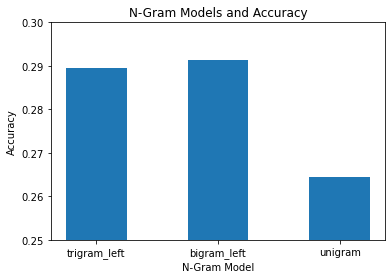

In [23]:
MAX_FILES= 260

## lists for storing accuracy of various methods
trigram_left_accuracy=[]
bigram_left_accuracy=[]
unigram_accuracy=[]

# Stopwords are not removed from training corpus
for known in [50]:
        construct_params = {
            "known" : known,
            "remove_stopwords" : False
        }

        # Initialize n-gram language model.
        mylm=my_language_model(trainingdir=trainingdir,files=training[:MAX_FILES], construct_params=construct_params)
        SCC = scc_reader()
        # Accuracy of method="trigram_left"
        trigram_left=SCC.predict_and_score(method="trigram_left")
        trigram_left_accuracy.append(trigram_left)
        # Accuracy of method="bigram_left"        
        bigram_left=SCC.predict_and_score(method="bigram_left")
        bigram_left_accuracy.append(bigram_left)
        # Accuracy of method="unigram"
        unigram=SCC.predict_and_score(method="unigram")
        unigram_accuracy.append(unigram)
        
        
        print("Trained on {} files, Accuracy of trigram_left with {} known words = {}".format(MAX_FILES,known,trigram_left))
        print("Trained on {} files, Accuracy of bigram_left with {} known words = {}".format(MAX_FILES,known,bigram_left))
        print("Trained on {} files, Accuracy of unigram with {} known words  = {}".format(MAX_FILES,known,unigram))

    
data_dict = {'trigram_left':trigram_left, 'bigram_left':bigram_left, 'unigram':unigram}
n_gram = list(data_dict.keys())
accuracy = list(data_dict.values())

#  Bar plot
plt.ylim(.25, .30)
plt.bar(n_gram, accuracy,
        width = 0.5)
plt.xlabel("N-Gram Model")
plt.ylabel("Accuracy")
plt.title("N-Gram Models and Accuracy")
plt.show()
        

# Word2Vec

In [24]:
def processfiles():
    """
    Code adapted from n_gram_language_model class definition.
    Returns lists of preprocessed and not tokenized sentences.
    """
    sentences = []
    sentences_preprocessed = []
    for afile in tqdm.tqdm(training):
        # print("Processing {}".format(afile))
        try:
            with open(os.path.join(trainingdir,afile)) as instream:
                for line in instream:
                    line=line.rstrip()
                    if len(line)>0:
                        tokens = [token for token in tokenize(line) if token not in stop_puncs]
                        sentences_preprocessed.append(tokens)
                        tokens = [token for token in tokenize(line)]
                        sentences.append(tokens)
        except UnicodeDecodeError:
            print("\nUnicodeDecodeError processing {}: ignoring rest of file".format(afile))
    return sentences,sentences_preprocessed

In [25]:
sentences,sentences_preprocessed =processfiles()

100%|████████████████████████████████████████████████████████████████████████████████| 261/261 [11:51<00:00,  2.73s/it]


#### Word2Vec Accuracy based on varying filesizes

 34%|███████████████████████████▌                                                     | 34/100 [01:19<03:08,  2.86s/it]


 32%|█████████████████████████▉                                                       | 64/200 [02:28<04:23,  1.94s/it]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [06:48<00:09,  2.26s/it]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [15:28<00:00, 185.74s/it]


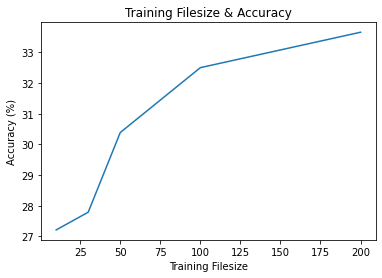

In [76]:
## Accuracy based on varying filesizes
word2vec_cos_files=[]

file_size=[10,30,50,100,200]

for file in tqdm.tqdm((file_size)):
    sentences_tmp,sentences_preprocessed_tmp=processfiles(file)
    mymodel=Word2Vec(sentences_preprocessed_tmp,epochs=5,seed=1,workers=8)
    SCC = scc_reader()
    word2vec_cos=SCC.predict_and_score(method="embedding_similarity_cos")
    word2vec_cos_files.append(word2vec_cos*100)
    
plt.plot(file_size,word2vec_cos_files)
plt.xlabel("Training Filesize")
plt.ylabel("Accuracy (%)")
plt.title('Training Filesize & Accuracy')
plt.show()

#### Word2Vec Accuracy based on epoch

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [12:46<00:00, 153.23s/it]


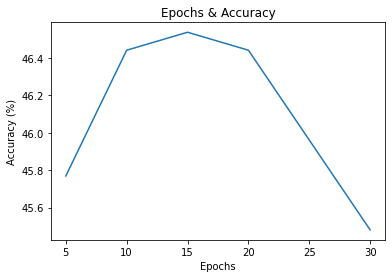

In [28]:
## Accuracy based on varying epochs
word2vec_cos_epoch=[]

epochs=[5,10,15,20,30]

for epoch in tqdm.tqdm((epochs)):
    mymodel=Word2Vec(sentences=sentences_preprocessed,epochs=epoch,seed=1,workers=7)
    SCC = scc_reader()
    word2vec_cos=SCC.predict_and_score(method="embedding_similarity_cos")
    word2vec_cos_epoch.append(word2vec_cos*100)
    
plt.plot(epochs,word2vec_cos_epoch) 
#plt.axis([0, 6, 0, 20])
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title('Epochs & Accuracy')
plt.show()

#### Word2Vec Accuracy based on negative

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:30<00:00, 52.55s/it]


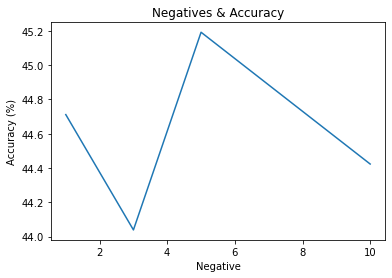

In [29]:
## Accuracy based on varying negative parameter
word2vec_cos_negative=[]

negative=[1,3,5,10]


for neg in tqdm.tqdm((negative)):
    mymodel=Word2Vec(sentences=sentences_preprocessed,negative=neg,seed=1,workers=7)
    SCC = scc_reader()
    word2vec_cos=SCC.predict_and_score(method="embedding_similarity_cos")
    word2vec_cos_negative.append(word2vec_cos*100)
    
plt.plot(negative,word2vec_cos_negative) 

plt.xlabel("Negative")
plt.ylabel("Accuracy (%)")
plt.title('Negatives & Accuracy')
plt.show()

#### Word2Vec Accuracy based on vector sizes

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:33<00:00, 54.72s/it]


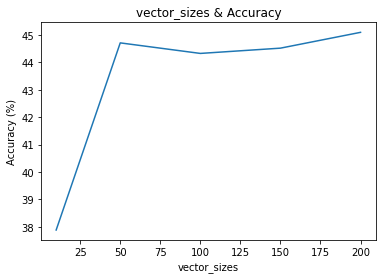

In [30]:
## Accuracy based on varying vector sizes
word2vec_cos_vector_size=[]
vector_sizes = [10, 50,100,150, 200]
for vector_size in tqdm.tqdm((vector_sizes)):
    mymodel=Word2Vec(sentences=sentences_preprocessed,vector_size=vector_size,seed=1,workers=7)
    SCC = scc_reader()
    word2vec_cos=SCC.predict_and_score(method="embedding_similarity_cos")
    word2vec_cos_vector_size.append(word2vec_cos*100)
    
plt.plot(vector_sizes,word2vec_cos_vector_size)
plt.xlabel("vector_sizes")
plt.ylabel("Accuracy (%)")
plt.title('vector_sizes & Accuracy')
plt.show()

#### Word2Vec Accuracy based on learning rate

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [04:44<00:00, 47.36s/it]


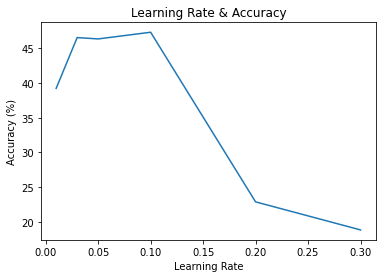

In [31]:
## Accuracy based on varying learning rate
word2vec_cos_lr=[]
lr = [0.01, 0.03 , 0.05 , 0.1 ,0.2 ,0.3]
for alpha in tqdm.tqdm((lr)):
    mymodel=Word2Vec(sentences=sentences_preprocessed,alpha=alpha,seed=1,workers=7)
    SCC = scc_reader()
    word2vec_cos=SCC.predict_and_score(method="embedding_similarity_cos")
    word2vec_cos_lr.append(word2vec_cos*100)
    
plt.plot(lr, word2vec_cos_lr)
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy (%)")
plt.title('Learning Rate & Accuracy')
plt.show()

#### Word2Vec Accuracy based on varying window size

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:01<00:00, 48.23s/it]


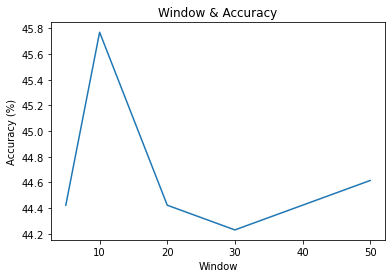

In [32]:
## Accuracy based on varying window size
word2vec_cos_window=[]
windows = [5,10,20,30,50]
for window in tqdm.tqdm((windows)):
    mymodel=Word2Vec(sentences=sentences_preprocessed,window=window,workers=7)
    SCC = scc_reader()
    word2vec_cos=SCC.predict_and_score(method="embedding_similarity_cos")
    word2vec_cos_window.append(word2vec_cos*100)
    
plt.plot(windows, word2vec_cos_window) 
plt.xlabel("Window")
plt.ylabel("Accuracy (%)")
plt.title('Window & Accuracy')
plt.show()

### Best performing word embedding model after pre-processing

In [26]:
## Accuracy for best performing word embedding model after pre-processing
mymodel=Word2Vec(sentences= sentences_preprocessed, window=5, vector_size=100, sg=1, negative=5, alpha=0.05, epochs=15, seed=1)
# Word2Vec- Word Embedding similarity scores after pre-processed
SCC = scc_reader()
# Cosine Similarity score for calculating accuracy
word2vec_cos=SCC.predict_and_score(method="embedding_similarity_cos")
print("Accuracy of word2vec trained on Gutenberg corpus after pre-processing  = {}".format(word2vec_cos))


Accuracy of word2vec trained on Gutenberg corpus after pre-processing  = 0.5278846153846154


### Best performing word embedding model before pre-processing

In [34]:
## Accuracy for best performing word embedding model before pre-processing
mymodel=Word2Vec(sentences= sentences, window=5, vector_size=100, sg=1, negative=5, alpha=0.05, epochs=15, seed=1)
# Word2Vec- Word Embedding similarity scores before pre-processing
SCC = scc_reader()
# Cosine Similarity score for calculating accuracy
word2vec_cos=SCC.predict_and_score(method="embedding_similarity_cos")
print("Accuracy of word2vec trained on Gutenberg corpus without pre-processing = {}".format(word2vec_cos))


Accuracy of word2vec trained on Gutenberg corpus without pre-processing = 0.44134615384615383


### Pretrained word embedding model

In [27]:
## Accuracy for pre-trained word embedding model
# Word2Vec- Word Embedding similarity scores
SCC = scc_reader()

# Cosine Similarity score for calculating accuracy
word2vec_pretrained_cos=SCC.predict_and_score(method="embedding_similarity_pretrained_cos")
print("Accuracy of word2vec pre-trained (google-news vector) = {}".format(word2vec_pretrained_cos))

Accuracy of word2vec pre-trained (google-news vector) = 0.3605769230769231


# BERT

In [28]:
# dictionary for choices
answers={
    0:'a',
    1:'b',
    2:'c',
    3:'d',
    4:'e'
}

def get_options_indices(tokenizer,prefix,options):
    """
    Function to convert choices in text form into ids of the tokenizer

    Arguments:
    - tokenizer: PretrainedTokenizer
    - prefix : (whitespace)
    - options: list

    Return: indices of each option's text (list)
    """
    # Tokenize input
    indices=[tokenizer(option)['input_ids'][1:-1] for option in options]
    for i,option in enumerate(options):
        if prefix+option in tokenizer.vocab.keys():
            indices[i]=[tokenizer.convert_tokens_to_ids(prefix+option)]
    return indices

## this is a handy way of finding the cosine similarity between two tensors
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)

class pretrained_model_tester():
    
    """
    Class setting up the BERT for Microsoft Sentence Completion Challenge
    
    Parameters : type
    -----------------
    
    test_df : dataframe
        Dataframe containg test questions for sentence completion challenge
   
    
    Attributes
    ----------
    tokenizer : PretrainedTokenizer
        Pretrained model tokenizer - BERT base-uncased
    model : 
        Pre-trained masked model (weights) - BERT base-uncased
    model.eval() : 
        Set the model in evaluation mode to deactivate the DropOut modules
    test_data : dataframe
        Copy of dataframe containg the questions for sentence completion challenge
    prefix : whitespace
        
    """
    def __init__(self,test_df):
        
        # Load pre-trained model tokenizer (vocabulary)
        self.tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')
        # Load pre-trained masked model (weights)
        self.model=BertForMaskedLM.from_pretrained('bert-base-uncased')
        # Set the model in evaluation mode to deactivate the DropOut modules
        # This is IMPORTANT to have reproducible results during evaluation!
        self.model.eval()
        # If you have a GPU, put everything on cuda - otherwise comment this out to run on CPU
        #self.model.to('cuda')
        self.test_data=test_df.copy()
        # replacing '_____' with '[MASK]'
        self.test_data.question=self.test_data.question.str.replace('_____','[MASK]')
        # prefix ''
        self.prefix=''
        
        
    def predict(self,question,options,pooling_method):
        """
        Perform sentence splitting, tokenizing, applying model and get result.

        Arguments:
        - question: string
            text with masked token
        - options: list of string
            option to be chosen
        - pooling_method: string
            `sum` (summing all the embedding of tokens together) or `mean` (averaging all the embedding of tokens together)

        Return: index of the option chosen (int)
        """
        # tokenizing question using BertTokenizer
        inputs=self.tokenizer(question,return_tensors='pt')
        # move to gpu if available
        #inputs={key: value.to(device) for key, value in inputs.items()}
        
        # tokenizing options using BertTokenizer
        masked_index=np.where((inputs['input_ids']==self.tokenizer.mask_token_id).cpu())[1][0]
        options_indices=get_options_indices(self.tokenizer,self.prefix,options)
        # get result : Predict all tokens 
        with torch.no_grad():
            outputs= self.model(**inputs)[0]
            options_indices=[option[0] for option in options_indices]
            outputs=outputs[:,masked_index,options_indices]
            return torch.argmax(outputs).item()
    
    def batch_predict(self,pooling_method='sum'):
        """
        Perform prediction on the whole test df

        Arguments:
        - pooling_method: string
            `sum` (summing all the embedding of tokens together) or `mean` (averaging all the embedding of tokens together)

        Return: answers of the questions (pandas series) 
        """
        result=[]
        for index, row in self.test_data.iterrows():
            question=row[0]
            options=row[1:].tolist()
            predicted_ind=self.predict(question,options,pooling_method)
            result.append(answers[predicted_ind])
        return pd.Series(result,index=test_data.index)
        
    def get_accuracy(prediction,labels):
        """
        Returns the accuracy of model
        """
        return sum(prediction==labels)/len(labels)             

### Best performing model for MSR SCC

In [29]:
# loading testing_data csv to pandas dataframe
test_data=pd.read_csv(os.path.join(parentdir,'testing_data.csv'),index_col=0)
# loading test_answer csv to pandas dataframe
test_answer=pd.read_csv(os.path.join(parentdir,'test_answer.csv'),index_col=0).iloc[:,0]

# loading the training dataset into BERT pretrained model
pretrained_model=pretrained_model_tester(test_data)
predictions=pretrained_model.batch_predict(pooling_method='sum')
# finding the accuracy of BERT model for Microsoft Sentence completion challenge
accuracy= pretrained_model_tester.get_accuracy(predictions,test_answer)
print("Accuracy with BERT base uncased = {}".format(accuracy))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Accuracy with BERT base uncased = 0.75


# Error Analysis

In [30]:
#read in the answer file
holding_list = []
with open(r"C:\Users\jovyj\Downloads\ANLP-22\lab2resources\sentence-completion\test_answer.csv") as instream:
    csvreader=csv.reader(instream)
    alines=list(csvreader)
    holding_list.append(alines)
answers = [holding_list[0][i][1] for i, _ in enumerate(holding_list[0]) if i != 0]

In [31]:
construct_params = {
            "known" : 3,
            "remove_stopwords" : False
        }
# Initialize n-gram language model.
mylm=my_language_model(trainingdir=trainingdir,files=training[:50], construct_params=construct_params)
SCC = scc_reader()
# Accuracy of method="trigram_left"
trigram_left=SCC.predict_and_score(method="trigram_left")        

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:03<00:00,  2.47s/it]


In [32]:
# creating a list of correct answers predicted by BERT
correct_answers_bert= []
for i in range(1,1041) :
    if predictions[i] == test_answer[i] :
        correct_answers_bert.append(1)

    elif predictions[i] != test_answer[i] :
        correct_answers_bert.append(0)   

In [33]:
## appending the BERT correct answer list to correct answer prediction dictionary 
correct_answers ["bert"] = correct_answers_bert

In [35]:
# All correct.
all_correct = []
# All incorrect.
all_incorrect = []
# n-gram over pretrained embedding.
n_g_vs_pre_emb = []
# pretrained embedding over n-gram.
pre_emb_vs_n_g = []
# n-gram over gutenberg trained embedding.
n_g_vs_emb = []
# gutenberg trained embedding over n-gram.
emb_vs_n_g = []


# gutenberg trained embedding over pre-trained embedding 
emb_vs_pre_emb=[]
# pre-trained embedding over gutenberg trained embedding embedding
pre_emb_vs_emb=[]

# only bert predicted correctly
bert_only = []

for i, (n_g, emb, pre_emb, bert) in enumerate(zip(correct_answers["trigram_left"], correct_answers["embedding_similarity_cos"],correct_answers["embedding_similarity_pretrained_cos"],correct_answers["bert"])):
    
    if n_g == emb == pre_emb ==bert== 1:
        all_correct.append(i)
    if n_g == emb == pre_emb ==bert== 0:
        all_incorrect.append(i)
    if n_g == 1 and emb == 0:
        n_g_vs_emb.append(i)
    if n_g == 0 and emb == 1:
        emb_vs_n_g.append(i)   
    if emb == 1 and pre_emb == 0:
        emb_vs_pre_emb.append(i)
    if emb == 0 and pre_emb == 1:
        pre_emb_vs_emb.append(i) 
    if bert == 1:
        bert_only.append(i)

In [36]:
def error_analysis(index):
    
  """
  Function to display answers predicted by each model, along with the question tokenized as well as in origial sentence.
  The correct answer is also printed to compare the predictions of each models.
  """

  que = question([SCC.get_field("id")[index], SCC.get_field("question")[index], SCC.get_field("a)")[index], SCC.get_field("b)")[index],SCC.get_field("c)")[index], SCC.get_field("d)")[index], SCC.get_field("e)")[index]])
  answer = answers[index]
  # n-gram prediction
  pred_ngram = que.predict(method="trigram_left")
  answer_ngram = SCC.get_field("{})".format(pred_ngram))[index]
  # custom word2vec prediction
  pred_emb = que.predict("embedding_similarity_cos")
  answer_emb = SCC.get_field("{})".format(pred_emb))[index]
  # pre-trained word2vec predictions
  pred_pre_emb = que.predict("embedding_similarity_pretrained_cos")
  answer_pre_emb = SCC.get_field("{})".format(pred_pre_emb))[index]
  ## bert predictions
  pred_bert = predictions[index+1]
  answer_bert = SCC.get_field("{})".format(pred_bert))[index]

  # correct answer for each challenge
  answer_correct = SCC.get_field("{})".format(answers[index]))[index]

  print("------------------------------QUESTION------------------------------")
  print(SCC.get_field("question")[index])
  print("\nQUESTION TOKENS ")
  print(que.get_tokens())

  print("\n\nCORRECT ANSWER : {}".format(answer_correct))

  print("\nPREDICTED ANSWER------------------------------")
  print("Trigram: {}".format(answer_ngram))
  print("Word2Vec trained on Gutengerg corpus: {}".format(answer_emb))
  print("Word2Vec pre-trained :{}".format(answer_pre_emb))
  print("BERT :{}".format(answer_bert))  
  print("------------------------------END OF QUESTION-----------------------")
  print()


In [46]:
# error analysis comparing custom and pre-trained word2vec
[error_analysis(index) for index in emb_vs_pre_emb]

------------------------------QUESTION------------------------------
I have it from the same source that you are both an orphan and a bachelor and are _____ alone in London.

QUESTION TOKENS 
['__START', 'I', 'have', 'it', 'from', 'the', 'same', 'source', 'that', 'you', 'are', 'both', 'an', 'orphan', 'and', 'a', 'bachelor', 'and', 'are', '_____', 'alone', 'in', 'London', '.', '__END']


CORRECT ANSWER : residing

PREDICTED ANSWER------------------------------
Trigram: crying
Word2Vec trained on Gutengerg corpus: residing
Word2Vec pre-trained :crying
BERT :residing
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
There is no _____ between them , but they all open out into the same corridor.

QUESTION TOKENS 
['__START', 'There', 'is', 'no', '_____', 'between', 'them', ',', 'but', 'they', 'all', 'open', 'out', 'into', 'the', 'same', 'corridor', '.', '__END']


CORRECT ANSWER : communication

PREDICT

------------------------------QUESTION------------------------------
His hair and whiskers were shot with gray , and his face was all crinkled and _____ like a withered apple.

QUESTION TOKENS 
['__START', 'His', 'hair', 'and', 'whiskers', 'were', 'shot', 'with', 'gray', ',', 'and', 'his', 'face', 'was', 'all', 'crinkled', 'and', '_____', 'like', 'a', 'withered', 'apple', '.', '__END']


CORRECT ANSWER : puckered

PREDICTED ANSWER------------------------------
Trigram: hopeful
Word2Vec trained on Gutengerg corpus: glistening
Word2Vec pre-trained :glistening
BERT :glistening
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
The point is a simple one , but the Inspector had _____ it because he had started with the supposition that these county magnates had had nothing to do with the matter.

QUESTION TOKENS 
['__START', 'The', 'point', 'is', 'a', 'simple', 'one', ',', 'but', 'the', 'Inspector', 'had'

------------------------------QUESTION------------------------------
Why should I slink away without having carried out my commission , and without the _____ which was my due.

QUESTION TOKENS 
['__START', 'Why', 'should', 'I', 'slink', 'away', 'without', 'having', 'carried', 'out', 'my', 'commission', ',', 'and', 'without', 'the', '_____', 'which', 'was', 'my', 'due', '.', '__END']


CORRECT ANSWER : payment

PREDICTED ANSWER------------------------------
Trigram: countenance
Word2Vec trained on Gutengerg corpus: payment
Word2Vec pre-trained :countenance
BERT :payment
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
Major Murphy , to whom I owe most of my _____ , assures me that he has never heard of any misunderstanding between the pair.

QUESTION TOKENS 
['__START', 'Major', 'Murphy', ',', 'to', 'whom', 'I', 'owe', 'most', 'of', 'my', '_____', ',', 'assures', 'me', 'that', 'he', 'has', 'never',

------------------------------QUESTION------------------------------
Together we _____ into the room.

QUESTION TOKENS 
['__START', 'Together', 'we', '_____', 'into', 'the', 'room', '.', '__END']


CORRECT ANSWER : rushed

PREDICTED ANSWER------------------------------
Trigram: rolled
Word2Vec trained on Gutengerg corpus: whirled
Word2Vec pre-trained :swelled
BERT :rushed
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
Who were these German people , and what were they doing living in this strange , _____ place.

QUESTION TOKENS 
['__START', 'Who', 'were', 'these', 'German', 'people', ',', 'and', 'what', 'were', 'they', 'doing', 'living', 'in', 'this', 'strange', ',', '_____', 'place', '.', '__END']


CORRECT ANSWER : out-of-the-way

PREDICTED ANSWER------------------------------
Trigram: impossible
Word2Vec trained on Gutengerg corpus: out-of-the-way
Word2Vec pre-trained :impossible
BERT :impossi

------------------------------QUESTION------------------------------
I was the only passenger who got out there , and there was no one upon the platform save a single sleepy _____ with a lantern.

QUESTION TOKENS 
['__START', 'I', 'was', 'the', 'only', 'passenger', 'who', 'got', 'out', 'there', ',', 'and', 'there', 'was', 'no', 'one', 'upon', 'the', 'platform', 'save', 'a', 'single', 'sleepy', '_____', 'with', 'a', 'lantern', '.', '__END']


CORRECT ANSWER : porter

PREDICTED ANSWER------------------------------
Trigram: audience
Word2Vec trained on Gutengerg corpus: porter
Word2Vec pre-trained :audience
BERT :waiter
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
They were _____ by a confederate inside the house.

QUESTION TOKENS 
['__START', 'They', 'were', '_____', 'by', 'a', 'confederate', 'inside', 'the', 'house', '.', '__END']


CORRECT ANSWER : admitted

PREDICTED ANSWER-------------------

------------------------------QUESTION------------------------------
Running up , I _____ its brains out , and it fell over with its keen white teeth still meeting in the great creases of his neck.

QUESTION TOKENS 
['__START', 'Running', 'up', ',', 'I', '_____', 'its', 'brains', 'out', ',', 'and', 'it', 'fell', 'over', 'with', 'its', 'keen', 'white', 'teeth', 'still', 'meeting', 'in', 'the', 'great', 'creases', 'of', 'his', 'neck', '.', '__END']


CORRECT ANSWER : blew

PREDICTED ANSWER------------------------------
Trigram: blew
Word2Vec trained on Gutengerg corpus: blew
Word2Vec pre-trained :dragged
BERT :blew
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
I had never seen my friend's face so _____ or his brow so dark as it was when we turned from the scene of this investigation.

QUESTION TOKENS 
['__START', 'I', 'had', 'never', 'seen', 'my', 'friend', "'s", 'face', 'so', '_____', 'or', 'his

------------------------------QUESTION------------------------------
When he raised his face again , I was _____ to see that his cheek was tinged with color , and his eyes as bright as before his illness.

QUESTION TOKENS 
['__START', 'When', 'he', 'raised', 'his', 'face', 'again', ',', 'I', 'was', '_____', 'to', 'see', 'that', 'his', 'cheek', 'was', 'tinged', 'with', 'color', ',', 'and', 'his', 'eyes', 'as', 'bright', 'as', 'before', 'his', 'illness', '.', '__END']


CORRECT ANSWER : surprised

PREDICTED ANSWER------------------------------
Trigram: surprised
Word2Vec trained on Gutengerg corpus: unaccustomed
Word2Vec pre-trained :anxious
BERT :surprised
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
The brother scribbled a note upon a leaf of his _____ , and , ringing the bell , he handed it to the waiter.

QUESTION TOKENS 
['__START', 'The', 'brother', 'scribbled', 'a', 'note', 'upon', 'a', '

------------------------------QUESTION------------------------------
There could be no question that the most distinctive and suggestive point in the case was the _____ disappearance of the door-key.

QUESTION TOKENS 
['__START', 'There', 'could', 'be', 'no', 'question', 'that', 'the', 'most', 'distinctive', 'and', 'suggestive', 'point', 'in', 'the', 'case', 'was', 'the', '_____', 'disappearance', 'of', 'the', 'door-key', '.', '__END']


CORRECT ANSWER : singular

PREDICTED ANSWER------------------------------
Trigram: singular
Word2Vec trained on Gutengerg corpus: secretive
Word2Vec pre-trained :genuine
BERT :genuine
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
No one could pass these _____ if they were bolted.

QUESTION TOKENS 
['__START', 'No', 'one', 'could', 'pass', 'these', '_____', 'if', 'they', 'were', 'bolted', '.', '__END']


CORRECT ANSWER : shutters

PREDICTED ANSWER---------------

------------------------------QUESTION------------------------------
If the former , she had probably _____ the photograph to his keeping.

QUESTION TOKENS 
['__START', 'If', 'the', 'former', ',', 'she', 'had', 'probably', '_____', 'the', 'photograph', 'to', 'his', 'keeping', '.', '__END']


CORRECT ANSWER : transferred

PREDICTED ANSWER------------------------------
Trigram: adorned
Word2Vec trained on Gutengerg corpus: transferred
Word2Vec pre-trained :assumed
BERT :transferred
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
Her story got about , and several of the people here did something to enable her to _____ an honest living.

QUESTION TOKENS 
['__START', 'Her', 'story', 'got', 'about', ',', 'and', 'several', 'of', 'the', 'people', 'here', 'did', 'something', 'to', 'enable', 'her', 'to', '_____', 'an', 'honest', 'living', '.', '__END']


CORRECT ANSWER : earn

PREDICTED ANSWER-------------

------------------------------QUESTION------------------------------
It was a delicate point , and it _____ the field of my inquiry.

QUESTION TOKENS 
['__START', 'It', 'was', 'a', 'delicate', 'point', ',', 'and', 'it', '_____', 'the', 'field', 'of', 'my', 'inquiry', '.', '__END']


CORRECT ANSWER : widened

PREDICTED ANSWER------------------------------
Trigram: whispered
Word2Vec trained on Gutengerg corpus: widened
Word2Vec pre-trained :whispered
BERT :widened
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
It was worth an effort to find out , and for that _____ we all went up to the house.

QUESTION TOKENS 
['__START', 'It', 'was', 'worth', 'an', 'effort', 'to', 'find', 'out', ',', 'and', 'for', 'that', '_____', 'we', 'all', 'went', 'up', 'to', 'the', 'house', '.', '__END']


CORRECT ANSWER : object

PREDICTED ANSWER------------------------------
Trigram: object
Word2Vec trained on Gutengerg 

------------------------------QUESTION------------------------------
Holmes and the Inspector led us round it until we came to the side gate , which is _____ by a stretch of garden from the hedge which lines the road.

QUESTION TOKENS 
['__START', 'Holmes', 'and', 'the', 'Inspector', 'led', 'us', 'round', 'it', 'until', 'we', 'came', 'to', 'the', 'side', 'gate', ',', 'which', 'is', '_____', 'by', 'a', 'stretch', 'of', 'garden', 'from', 'the', 'hedge', 'which', 'lines', 'the', 'road', '.', '__END']


CORRECT ANSWER : separated

PREDICTED ANSWER------------------------------
Trigram: caused
Word2Vec trained on Gutengerg corpus: separated
Word2Vec pre-trained :watered
BERT :separated
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
Mr. Cunningham had just got into bed , and Mr. Alec was _____ a pipe in his dressing-gown.

QUESTION TOKENS 
['__START', 'Mr.', 'Cunningham', 'had', 'just', 'got', 'into',

------------------------------QUESTION------------------------------
I have made a small _____ of tattoo marks and have even contributed to the literature of the subject.

QUESTION TOKENS 
['__START', 'I', 'have', 'made', 'a', 'small', '_____', 'of', 'tattoo', 'marks', 'and', 'have', 'even', 'contributed', 'to', 'the', 'literature', 'of', 'the', 'subject', '.', '__END']


CORRECT ANSWER : study

PREDICTED ANSWER------------------------------
Trigram: crowd
Word2Vec trained on Gutengerg corpus: study
Word2Vec pre-trained :circle
BERT :study
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
When he reached the _____ I saw the ragged uncouth figure outlined for an instant against the cold blue sky.

QUESTION TOKENS 
['__START', 'When', 'he', 'reached', 'the', '_____', 'I', 'saw', 'the', 'ragged', 'uncouth', 'figure', 'outlined', 'for', 'an', 'instant', 'against', 'the', 'cold', 'blue', 'sky', '.', '__

------------------------------QUESTION------------------------------
Nothing would induce me to help the _____ in any way.

QUESTION TOKENS 
['__START', 'Nothing', 'would', 'induce', 'me', 'to', 'help', 'the', '_____', 'in', 'any', 'way', '.', '__END']


CORRECT ANSWER : police

PREDICTED ANSWER------------------------------
Trigram: police
Word2Vec trained on Gutengerg corpus: police
Word2Vec pre-trained :reader
BERT :police
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
Mr. Jabez Wilson started up in his chair , with his _____ upon the paper , but his eyes upon my companion.

QUESTION TOKENS 
['__START', 'Mr.', 'Jabez', 'Wilson', 'started', 'up', 'in', 'his', 'chair', ',', 'with', 'his', '_____', 'upon', 'the', 'paper', ',', 'but', 'his', 'eyes', 'upon', 'my', 'companion', '.', '__END']


CORRECT ANSWER : forefinger

PREDICTED ANSWER------------------------------
Trigram: dogs
Word2Vec trained

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [55]:
# error analysis comparing custom word2vec and n-gram
len([error_analysis(index) for index in emb_vs_n_g])

------------------------------QUESTION------------------------------
I have it from the same source that you are both an orphan and a bachelor and are _____ alone in London.

QUESTION TOKENS 
['__START', 'I', 'have', 'it', 'from', 'the', 'same', 'source', 'that', 'you', 'are', 'both', 'an', 'orphan', 'and', 'a', 'bachelor', 'and', 'are', '_____', 'alone', 'in', 'London', '.', '__END']


CORRECT ANSWER : residing

PREDICTED ANSWER------------------------------
Trigram: crying
Word2Vec trained on Gutengerg corpus: residing
Word2Vec pre-trained :crying
BERT :residing
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
As I descended , my old ally , the _____ , came out of the room and closed the door tightly behind him.

QUESTION TOKENS 
['__START', 'As', 'I', 'descended', ',', 'my', 'old', 'ally', ',', 'the', '_____', ',', 'came', 'out', 'of', 'the', 'room', 'and', 'closed', 'the', 'door', 'tightly', '

------------------------------QUESTION------------------------------
They say that away down in the village , and even in the distant parsonage , that cry raised the _____ from their beds.

QUESTION TOKENS 
['__START', 'They', 'say', 'that', 'away', 'down', 'in', 'the', 'village', ',', 'and', 'even', 'in', 'the', 'distant', 'parsonage', ',', 'that', 'cry', 'raised', 'the', '_____', 'from', 'their', 'beds', '.', '__END']


CORRECT ANSWER : sleepers

PREDICTED ANSWER------------------------------
Trigram: note
Word2Vec trained on Gutengerg corpus: sleepers
Word2Vec pre-trained :cup
BERT :forester
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
There he is , all _____ and sound.

QUESTION TOKENS 
['__START', 'There', 'he', 'is', ',', 'all', '_____', 'and', 'sound', '.', '__END']


CORRECT ANSWER : safe

PREDICTED ANSWER------------------------------
Trigram: dirty
Word2Vec trained on Gutengerg corpu

------------------------------QUESTION------------------------------
Mortimer had _____ to dinner , and he and the baronet played ecarte afterwards.

QUESTION TOKENS 
['__START', 'Mortimer', 'had', '_____', 'to', 'dinner', ',', 'and', 'he', 'and', 'the', 'baronet', 'played', 'ecarte', 'afterwards', '.', '__END']


CORRECT ANSWER : stayed

PREDICTED ANSWER------------------------------
Trigram: risen
Word2Vec trained on Gutengerg corpus: stayed
Word2Vec pre-trained :stayed
BERT :risen
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
Holmes had brought up a long thin _____ , and this he placed upon the bed beside him.

QUESTION TOKENS 
['__START', 'Holmes', 'had', 'brought', 'up', 'a', 'long', 'thin', '_____', ',', 'and', 'this', 'he', 'placed', 'upon', 'the', 'bed', 'beside', 'him', '.', '__END']


CORRECT ANSWER : cane

PREDICTED ANSWER------------------------------
Trigram: nose
Word2Vec trained 

------------------------------QUESTION------------------------------
Major Murphy , to whom I owe most of my _____ , assures me that he has never heard of any misunderstanding between the pair.

QUESTION TOKENS 
['__START', 'Major', 'Murphy', ',', 'to', 'whom', 'I', 'owe', 'most', 'of', 'my', '_____', ',', 'assures', 'me', 'that', 'he', 'has', 'never', 'heard', 'of', 'any', 'misunderstanding', 'between', 'the', 'pair', '.', '__END']


CORRECT ANSWER : facts

PREDICTED ANSWER------------------------------
Trigram: neck
Word2Vec trained on Gutengerg corpus: folly
Word2Vec pre-trained :folly
BERT :folly
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
Admiration was , I _____ , the first impression.

QUESTION TOKENS 
['__START', 'Admiration', 'was', ',', 'I', '_____', ',', 'the', 'first', 'impression', '.', '__END']


CORRECT ANSWER : repeat

PREDICTED ANSWER------------------------------
Trigram: ga

------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
Holmes cut the _____ and removed the transverse bar.

QUESTION TOKENS 
['__START', 'Holmes', 'cut', 'the', '_____', 'and', 'removed', 'the', 'transverse', 'bar', '.', '__END']


CORRECT ANSWER : cord

PREDICTED ANSWER------------------------------
Trigram: bread
Word2Vec trained on Gutengerg corpus: cord
Word2Vec pre-trained :cord
BERT :cord
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
It was a _____ little room , with a low ceiling and a gaping fireplace , after the fashion of old country-houses.

QUESTION TOKENS 
['__START', 'It', 'was', 'a', '_____', 'little', 'room', ',', 'with', 'a', 'low', 'ceiling', 'and', 'a', 'gaping', 'fireplace', ',', 'after', 'the', 'fashion', 'of', 'old', 'country-houses', '.', '__END']


CORRECT ANSWER : homely

PREDICTED ANSW

------------------------------QUESTION------------------------------
The wind was howling outside , and the rain was beating and _____ against the windows.

QUESTION TOKENS 
['__START', 'The', 'wind', 'was', 'howling', 'outside', ',', 'and', 'the', 'rain', 'was', 'beating', 'and', '_____', 'against', 'the', 'windows', '.', '__END']


CORRECT ANSWER : splashing

PREDICTED ANSWER------------------------------
Trigram: leaping
Word2Vec trained on Gutengerg corpus: splashing
Word2Vec pre-trained :staggering
BERT :splitting
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
Had he observed a _____ the night before waiting for me.

QUESTION TOKENS 
['__START', 'Had', 'he', 'observed', 'a', '_____', 'the', 'night', 'before', 'waiting', 'for', 'me', '.', '__END']


CORRECT ANSWER : carriage

PREDICTED ANSWER------------------------------
Trigram: picture
Word2Vec trained on Gutengerg corpus: carriage
Word2V

------------------------------QUESTION------------------------------
An elderly man with a red face and shaking limbs came _____ out at a side door.

QUESTION TOKENS 
['__START', 'An', 'elderly', 'man', 'with', 'a', 'red', 'face', 'and', 'shaking', 'limbs', 'came', '_____', 'out', 'at', 'a', 'side', 'door', '.', '__END']


CORRECT ANSWER : staggering

PREDICTED ANSWER------------------------------
Trigram: pouring
Word2Vec trained on Gutengerg corpus: daintily
Word2Vec pre-trained :staggering
BERT :staggering
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
The sun had set and _____ was settling over the moor.

QUESTION TOKENS 
['__START', 'The', 'sun', 'had', 'set', 'and', '_____', 'was', 'settling', 'over', 'the', 'moor', '.', '__END']


CORRECT ANSWER : dusk

PREDICTED ANSWER------------------------------
Trigram: laughter
Word2Vec trained on Gutengerg corpus: dusk
Word2Vec pre-trained :dusk
BE

------------------------------QUESTION------------------------------
You have at least the satisfaction of knowing that for thirty years of his life his _____ bitterly reproached him for this wicked deed.

QUESTION TOKENS 
['__START', 'You', 'have', 'at', 'least', 'the', 'satisfaction', 'of', 'knowing', 'that', 'for', 'thirty', 'years', 'of', 'his', 'life', 'his', '_____', 'bitterly', 'reproached', 'him', 'for', 'this', 'wicked', 'deed', '.', '__END']


CORRECT ANSWER : conscience

PREDICTED ANSWER------------------------------
Trigram: host
Word2Vec trained on Gutengerg corpus: wickedness
Word2Vec pre-trained :wickedness
BERT :conscience
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
Two hansoms were standing at the door , and as I entered the _____ I heard the sound of voices from above.

QUESTION TOKENS 
['__START', 'Two', 'hansoms', 'were', 'standing', 'at', 'the', 'door', ',', 'and', 'as', 

------------------------------QUESTION------------------------------
If you leave , you _____ your whole position forever.

QUESTION TOKENS 
['__START', 'If', 'you', 'leave', ',', 'you', '_____', 'your', 'whole', 'position', 'forever', '.', '__END']


CORRECT ANSWER : forfeit

PREDICTED ANSWER------------------------------
Trigram: spent
Word2Vec trained on Gutengerg corpus: drown
Word2Vec pre-trained :haven't
BERT :spent
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
However , I _____ all fears to the winds , ate a hearty supper , drove to Paddington , and started off , having obeyed to the letter the injunction as to holding my tongue.

QUESTION TOKENS 
['__START', 'However', ',', 'I', '_____', 'all', 'fears', 'to', 'the', 'winds', ',', 'ate', 'a', 'hearty', 'supper', ',', 'drove', 'to', 'Paddington', ',', 'and', 'started', 'off', ',', 'having', 'obeyed', 'to', 'the', 'letter', 'the', 'injunct

------------------------------QUESTION------------------------------
It was nearly _____ between the oak and the house.

QUESTION TOKENS 
['__START', 'It', 'was', 'nearly', '_____', 'between', 'the', 'oak', 'and', 'the', 'house', '.', '__END']


CORRECT ANSWER : midway

PREDICTED ANSWER------------------------------
Trigram: determined
Word2Vec trained on Gutengerg corpus: midway
Word2Vec pre-trained :determined
BERT :midway
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
I am only , of course , giving you the leading _____ now of my examination of the paper.

QUESTION TOKENS 
['__START', 'I', 'am', 'only', ',', 'of', 'course', ',', 'giving', 'you', 'the', 'leading', '_____', 'now', 'of', 'my', 'examination', 'of', 'the', 'paper', '.', '__END']


CORRECT ANSWER : results

PREDICTED ANSWER------------------------------
Trigram: spirits
Word2Vec trained on Gutengerg corpus: results
Word2Vec pre-tra

------------------------------QUESTION------------------------------
A splendid _____ with fine old timber surrounds the house , and the lake , to which my client had referred , lay close to the avenue , about two hundred yards from the building.

QUESTION TOKENS 
['__START', 'A', 'splendid', '_____', 'with', 'fine', 'old', 'timber', 'surrounds', 'the', 'house', ',', 'and', 'the', 'lake', ',', 'to', 'which', 'my', 'client', 'had', 'referred', ',', 'lay', 'close', 'to', 'the', 'avenue', ',', 'about', 'two', 'hundred', 'yards', 'from', 'the', 'building', '.', '__END']


CORRECT ANSWER : park

PREDICTED ANSWER------------------------------
Trigram: devil
Word2Vec trained on Gutengerg corpus: park
Word2Vec pre-trained :park
BERT :park
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
I often take advantage of the _____ which it gives.

QUESTION TOKENS 
['__START', 'I', 'often', 'take', 'advantage', 'of

------------------------------QUESTION------------------------------
Each daughter can claim an _____ of 250 pounds , in case of marriage.

QUESTION TOKENS 
['__START', 'Each', 'daughter', 'can', 'claim', 'an', '_____', 'of', '250', 'pounds', ',', 'in', 'case', 'of', 'marriage', '.', '__END']


CORRECT ANSWER : income

PREDICTED ANSWER------------------------------
Trigram: enemy
Word2Vec trained on Gutengerg corpus: income
Word2Vec pre-trained :opinion
BERT :income
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
The photograph is in a _____ behind a sliding panel just above the right bell-pull.

QUESTION TOKENS 
['__START', 'The', 'photograph', 'is', 'in', 'a', '_____', 'behind', 'a', 'sliding', 'panel', 'just', 'above', 'the', 'right', 'bell-pull', '.', '__END']


CORRECT ANSWER : recess

PREDICTED ANSWER------------------------------
Trigram: string
Word2Vec trained on Gutengerg corpus: recess

------------------------------QUESTION------------------------------
We shall just be in time to have a little _____ with him.

QUESTION TOKENS 
['__START', 'We', 'shall', 'just', 'be', 'in', 'time', 'to', 'have', 'a', 'little', '_____', 'with', 'him', '.', '__END']


CORRECT ANSWER : breakfast

PREDICTED ANSWER------------------------------
Trigram: dog
Word2Vec trained on Gutengerg corpus: breakfast
Word2Vec pre-trained :dog
BERT :breakfast
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
During my long and _____ acquaintance with Mr. Sherlock Holmes I had never heard him refer to his relations , and hardly ever to his own early life.

QUESTION TOKENS 
['__START', 'During', 'my', 'long', 'and', '_____', 'acquaintance', 'with', 'Mr.', 'Sherlock', 'Holmes', 'I', 'had', 'never', 'heard', 'him', 'refer', 'to', 'his', 'relations', ',', 'and', 'hardly', 'ever', 'to', 'his', 'own', 'early', 'life', '.'

------------------------------QUESTION------------------------------
The money which my mother had left was enough for all our _____ , and there seemed to be no obstacle to our happiness.

QUESTION TOKENS 
['__START', 'The', 'money', 'which', 'my', 'mother', 'had', 'left', 'was', 'enough', 'for', 'all', 'our', '_____', ',', 'and', 'there', 'seemed', 'to', 'be', 'no', 'obstacle', 'to', 'our', 'happiness', '.', '__END']


CORRECT ANSWER : wants

PREDICTED ANSWER------------------------------
Trigram: hunger
Word2Vec trained on Gutengerg corpus: success
Word2Vec pre-trained :wants
BERT :wants
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
He would try by a few attentions to make his peace with the girl Howells , and then would _____ her as his accomplice.

QUESTION TOKENS 
['__START', 'He', 'would', 'try', 'by', 'a', 'few', 'attentions', 'to', 'make', 'his', 'peace', 'with', 'the', 'girl', 'Howells

------------------------------QUESTION------------------------------
In my inmost heart I believed that I could _____ where others failed , and now I had the opportunity to test myself.

QUESTION TOKENS 
['__START', 'In', 'my', 'inmost', 'heart', 'I', 'believed', 'that', 'I', 'could', '_____', 'where', 'others', 'failed', ',', 'and', 'now', 'I', 'had', 'the', 'opportunity', 'to', 'test', 'myself', '.', '__END']


CORRECT ANSWER : succeed

PREDICTED ANSWER------------------------------
Trigram: lie
Word2Vec trained on Gutengerg corpus: succeed
Word2Vec pre-trained :forget
BERT :succeed
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
They were the only signs of human life which I could see , save only those prehistoric _____ which lay thickly upon the slopes of the hills.

QUESTION TOKENS 
['__START', 'They', 'were', 'the', 'only', 'signs', 'of', 'human', 'life', 'which', 'I', 'could', 'see', ',', 

344

In [54]:
# error analysis comparing n-gram and custom word2vec
len([error_analysis(index) for index in n_g_vs_emb])

------------------------------QUESTION------------------------------
Having once made up my mind , you know the _____ which I took in order to put the matter to the proof.

QUESTION TOKENS 
['__START', 'Having', 'once', 'made', 'up', 'my', 'mind', ',', 'you', 'know', 'the', '_____', 'which', 'I', 'took', 'in', 'order', 'to', 'put', 'the', 'matter', 'to', 'the', 'proof', '.', '__END']


CORRECT ANSWER : steps

PREDICTED ANSWER------------------------------
Trigram: steps
Word2Vec trained on Gutengerg corpus: hopelessness
Word2Vec pre-trained :steps
BERT :steps
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
Fresh scandals have eclipsed it , and their more piquant details have _____ the gossips away from this four-year-old drama.

QUESTION TOKENS 
['__START', 'Fresh', 'scandals', 'have', 'eclipsed', 'it', ',', 'and', 'their', 'more', 'piquant', 'details', 'have', '_____', 'the', 'gossips', 'away', 

------------------------------QUESTION------------------------------
The point is of the utmost _____ as guiding us towards the reason of the sudden quarrel.

QUESTION TOKENS 
['__START', 'The', 'point', 'is', 'of', 'the', 'utmost', '_____', 'as', 'guiding', 'us', 'towards', 'the', 'reason', 'of', 'the', 'sudden', 'quarrel', '.', '__END']


CORRECT ANSWER : importance

PREDICTED ANSWER------------------------------
Trigram: importance
Word2Vec trained on Gutengerg corpus: exertion
Word2Vec pre-trained :importance
BERT :importance
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
The smoke and _____ were enough to shake nerves of steel.

QUESTION TOKENS 
['__START', 'The', 'smoke', 'and', '_____', 'were', 'enough', 'to', 'shake', 'nerves', 'of', 'steel', '.', '__END']


CORRECT ANSWER : shouting

PREDICTED ANSWER------------------------------
Trigram: shouting
Word2Vec trained on Gutengerg corpus: u

------------------------------QUESTION------------------------------
The French or the Russian embassy would pay an immense sum to _____ the contents of these papers.

QUESTION TOKENS 
['__START', 'The', 'French', 'or', 'the', 'Russian', 'embassy', 'would', 'pay', 'an', 'immense', 'sum', 'to', '_____', 'the', 'contents', 'of', 'these', 'papers', '.', '__END']


CORRECT ANSWER : learn

PREDICTED ANSWER------------------------------
Trigram: learn
Word2Vec trained on Gutengerg corpus: prosecute
Word2Vec pre-trained :increase
BERT :learn
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
A few good _____ and the reputation which I had won in the hospital brought me rapidly to the front , and during the last few years I have made him a rich man.

QUESTION TOKENS 
['__START', 'A', 'few', 'good', '_____', 'and', 'the', 'reputation', 'which', 'I', 'had', 'won', 'in', 'the', 'hospital', 'brought', 'me', 'ra

------------------------------QUESTION------------------------------
Holmes dashed into the crowd to _____ the lady ; but just as he reached her he gave a cry and dropped to the ground , with the blood running freely down his face.

QUESTION TOKENS 
['__START', 'Holmes', 'dashed', 'into', 'the', 'crowd', 'to', '_____', 'the', 'lady', ';', 'but', 'just', 'as', 'he', 'reached', 'her', 'he', 'gave', 'a', 'cry', 'and', 'dropped', 'to', 'the', 'ground', ',', 'with', 'the', 'blood', 'running', 'freely', 'down', 'his', 'face', '.', '__END']


CORRECT ANSWER : protect

PREDICTED ANSWER------------------------------
Trigram: protect
Word2Vec trained on Gutengerg corpus: replace
Word2Vec pre-trained :abandon
BERT :protect
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
But here an unexpected and singular _____ presented itself.

QUESTION TOKENS 
['__START', 'But', 'here', 'an', 'unexpected', 'and', 'singul

------------------------------QUESTION------------------------------
It was the same good friend whose warning I had so _____ rejected.

QUESTION TOKENS 
['__START', 'It', 'was', 'the', 'same', 'good', 'friend', 'whose', 'warning', 'I', 'had', 'so', '_____', 'rejected', '.', '__END']


CORRECT ANSWER : foolishly

PREDICTED ANSWER------------------------------
Trigram: foolishly
Word2Vec trained on Gutengerg corpus: nobly
Word2Vec pre-trained :strangely
BERT :strangely
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
He had trained it , probably by the use of the _____ which we saw , to return to him when summoned.

QUESTION TOKENS 
['__START', 'He', 'had', 'trained', 'it', ',', 'probably', 'by', 'the', 'use', 'of', 'the', '_____', 'which', 'we', 'saw', ',', 'to', 'return', 'to', 'him', 'when', 'summoned', '.', '__END']


CORRECT ANSWER : milk

PREDICTED ANSWER------------------------------
Trigram

112

In [37]:
len([error_analysis(index) for index in all_incorrect])


------------------------------QUESTION------------------------------
It was furnished partly as a sitting and partly as a bedroom , with flowers arranged _____ in every nook and corner.

QUESTION TOKENS 
['__START', 'It', 'was', 'furnished', 'partly', 'as', 'a', 'sitting', 'and', 'partly', 'as', 'a', 'bedroom', ',', 'with', 'flowers', 'arranged', '_____', 'in', 'every', 'nook', 'and', 'corner', '.', '__END']


CORRECT ANSWER : daintily

PREDICTED ANSWER------------------------------
Trigram: comfortably
Word2Vec trained on Gutengerg corpus: comfortably
Word2Vec pre-trained :comfortably
BERT :comfortably
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
You can imagine my _____ , Watson , when within two inches of my peg I saw a conical depression in the ground.

QUESTION TOKENS 
['__START', 'You', 'can', 'imagine', 'my', '_____', ',', 'Watson', ',', 'when', 'within', 'two', 'inches', 'of', 'my', 'p

------------------------------QUESTION------------------------------
He took a small piece of torn paper from a _____ and spread it out upon his knee.

QUESTION TOKENS 
['__START', 'He', 'took', 'a', 'small', 'piece', 'of', 'torn', 'paper', 'from', 'a', '_____', 'and', 'spread', 'it', 'out', 'upon', 'his', 'knee', '.', '__END']


CORRECT ANSWER : note-book

PREDICTED ANSWER------------------------------
Trigram: pencil
Word2Vec trained on Gutengerg corpus: pencil
Word2Vec pre-trained :pencil
BERT :pencil
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
The walls were of wood , but the floor consisted of a large iron trough , and when I came to examine it I could see a _____ of metallic deposit all over it.

QUESTION TOKENS 
['__START', 'The', 'walls', 'were', 'of', 'wood', ',', 'but', 'the', 'floor', 'consisted', 'of', 'a', 'large', 'iron', 'trough', ',', 'and', 'when', 'I', 'came', 'to', 'examine

------------------------------QUESTION------------------------------
He is not a bad fellow , though an absolute _____ in his profession.

QUESTION TOKENS 
['__START', 'He', 'is', 'not', 'a', 'bad', 'fellow', ',', 'though', 'an', 'absolute', '_____', 'in', 'his', 'profession', '.', '__END']


CORRECT ANSWER : imbecile

PREDICTED ANSWER------------------------------
Trigram: experience
Word2Vec trained on Gutengerg corpus: faith
Word2Vec pre-trained :faith
BERT :contradiction
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
The rapidity with which such a _____ would take effect would also , from his point of view , be an advantage.

QUESTION TOKENS 
['__START', 'The', 'rapidity', 'with', 'which', 'such', 'a', '_____', 'would', 'take', 'effect', 'would', 'also', ',', 'from', 'his', 'point', 'of', 'view', ',', 'be', 'an', 'advantage', '.', '__END']


CORRECT ANSWER : poison

PREDICTED ANSWER---------

------------------------------QUESTION------------------------------
The lawn is thirty yards across , and is only _____ from the highway by a low wall with an iron rail above it.

QUESTION TOKENS 
['__START', 'The', 'lawn', 'is', 'thirty', 'yards', 'across', ',', 'and', 'is', 'only', '_____', 'from', 'the', 'highway', 'by', 'a', 'low', 'wall', 'with', 'an', 'iron', 'rail', 'above', 'it', '.', '__END']


CORRECT ANSWER : divided

PREDICTED ANSWER------------------------------
Trigram: visible
Word2Vec trained on Gutengerg corpus: divided
Word2Vec pre-trained :visible
BERT :visible
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
Now , there is no one more easy to _____ than a schoolmaster.

QUESTION TOKENS 
['__START', 'Now', ',', 'there', 'is', 'no', 'one', 'more', 'easy', 'to', '_____', 'than', 'a', 'schoolmaster', '.', '__END']


CORRECT ANSWER : trace

PREDICTED ANSWER-------------------------

------------------------------QUESTION------------------------------
His characteristic talk , with its keen _____ of detail and subtle power of inference held me amused and enthralled.

QUESTION TOKENS 
['__START', 'His', 'characteristic', 'talk', ',', 'with', 'its', 'keen', '_____', 'of', 'detail', 'and', 'subtle', 'power', 'of', 'inference', 'held', 'me', 'amused', 'and', 'enthralled', '.', '__END']


CORRECT ANSWER : observance

PREDICTED ANSWER------------------------------
Trigram: implements
Word2Vec trained on Gutengerg corpus: instincts
Word2Vec pre-trained :instincts
BERT :instincts
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
I did not know about a projected _____ between herself and her husband.

QUESTION TOKENS 
['__START', 'I', 'did', 'not', 'know', 'about', 'a', 'projected', '_____', 'between', 'herself', 'and', 'her', 'husband', '.', '__END']


CORRECT ANSWER : divorce

PREDICT

------------------------------QUESTION------------------------------
And yet it would be the _____ treachery to Holmes to draw back now from the part which he had intrusted to me.

QUESTION TOKENS 
['__START', 'And', 'yet', 'it', 'would', 'be', 'the', '_____', 'treachery', 'to', 'Holmes', 'to', 'draw', 'back', 'now', 'from', 'the', 'part', 'which', 'he', 'had', 'intrusted', 'to', 'me', '.', '__END']


CORRECT ANSWER : blackest

PREDICTED ANSWER------------------------------
Trigram: innocent
Word2Vec trained on Gutengerg corpus: innocent
Word2Vec pre-trained :innocent
BERT :innocent
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
His secret was a shameful one , and he could not bring himself to _____ it.

QUESTION TOKENS 
['__START', 'His', 'secret', 'was', 'a', 'shameful', 'one', ',', 'and', 'he', 'could', 'not', 'bring', 'himself', 'to', '_____', 'it', '.', '__END']


CORRECT ANSWER : divulge



Word2Vec pre-trained :log
BERT :log
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
Half a _____ if you do it in twenty minutes.

QUESTION TOKENS 
['__START', 'Half', 'a', '_____', 'if', 'you', 'do', 'it', 'in', 'twenty', 'minutes', '.', '__END']


CORRECT ANSWER : guinea

PREDICTED ANSWER------------------------------
Trigram: mile
Word2Vec trained on Gutengerg corpus: mile
Word2Vec pre-trained :farthing
BERT :mile
------------------------------END OF QUESTION-----------------------

------------------------------QUESTION------------------------------
All my _____ instincts rose up against that laugh.

QUESTION TOKENS 
['__START', 'All', 'my', '_____', 'instincts', 'rose', 'up', 'against', 'that', 'laugh', '.', '__END']


CORRECT ANSWER : medical

PREDICTED ANSWER------------------------------
Trigram: future
Word2Vec trained on Gutengerg corpus: yearning
Word2Vec pre-trained :yearning
BERT :sis

------------------------------QUESTION------------------------------
Our visitor bore every mark of being an average commonplace British tradesman , obese , _____ , and slow.

QUESTION TOKENS 
['__START', 'Our', 'visitor', 'bore', 'every', 'mark', 'of', 'being', 'an', 'average', 'commonplace', 'British', 'tradesman', ',', 'obese', ',', '_____', ',', 'and', 'slow', '.', '__END']


CORRECT ANSWER : pompous

PREDICTED ANSWER------------------------------
Trigram: blind
Word2Vec trained on Gutengerg corpus: eloquent
Word2Vec pre-trained :blind
BERT :blind
------------------------------END OF QUESTION-----------------------



121